# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})


/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if 'plz' not in locals():
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [4]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 62.2M  100 62.2M    0     0  1263k      0  0:00:50  0:00:50 --:--:-- 1793kM    0     0   771k      0  0:01:22  0:00:22  0:01:00 1449k9k      0  0:00:59  0:00:31  0:00:28 1752k  87 54.6M    0     0  1214k      0  0:00:52  0:00:46  0:00:06 1292k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 

In [5]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [6]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [7]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [8]:
df.reason.value_counts()

N                             602825
X                             340249
Y                              41976
A[B.1.617.2]                   35876
A[B.1.1.7]                     35832
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 241, dtype: int64

In [9]:
import re

In [10]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD... 2022-08-23      Y   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9... 2022-08-30      Y   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40... 2022-08-30      Y   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890... 2022-08-30      Y   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823... 2022-08-16      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...      2022-09-21      55131   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...      2022-09-21      55131   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...      2022-09-21      55131   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...      2022-09-21      55131   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...      2022-08-22      33617   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                       40225  B.1.1.297   
IMS-10294-CVDP-00325                                       40225    B.1.221   
IMS-10294-CVDP-00326                                       40225    B.1.160   
IMS-10294-CVDP-00327                                       40225    B.1.258   
IMS-10294-CVDP-00329                                       40225  B.1.1.521   
...                                                          ...        ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...         55131   BA.5.1.2   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...         55131     BA.5.1   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...         55131   BA.5.1.2   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...         55131   BA.5.1.2   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...         24106     BA.5.2   

                                                   scorpio  \
IMS_ID                                                       
IMS-10294-CVDP-00001                                   NaN   
IMS-10294-CVDP-00325                                   NaN   
IMS-10294-CVDP-00326                                   NaN   
IMS-10294-CVDP-00327                                   NaN   
IMS-10294-CVDP-00329                                   NaN   
...                                                    ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...     NaN   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...     NaN   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...     NaN   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...     NaN   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...     NaN   

                                                             bundesland  
IMS_ID                                                                   
IMS-10294-CVDP-00001                                Nordrhein-Westfalen  
IMS-10294

In [11]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.2       2962
BA.5.1       2231
BA.5.2.1     1920
BF.7         1484
BE.1.1        908
             ... 
BQ.1.4          1
BA.5.3.4        1
BM.4.1.1        1
BA.4.2          1
BA.5.1.18       1
Name: lineage, Length: 171, dtype: int64

In [12]:
start_date = "2021-01-01"
d = df.loc[df.date >= start_date,:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [13]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
#ba

In [14]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
#d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       A.19  A.2.5  A.2.5.2  A.23.1  A.27  A.28  A.29  \
bundesland        date                                                         
Baden-Württemberg 2021-01-01     0      0        0       0     0     0     0   
                  2021-01-02     0      0        0       0     0     0     0   
                  2021-01-03     0      0        0       0     0     0     0   
                  2021-01-04     0      0        0       0     0     0     0   
                  2021-01-05     0      0        0       0     0     0     0   
...                            ...    ...      ...     ...   ...   ...   ...   
Thüringen         2022-10-02     0      0        0       0     0     0     0   
                  2022-10-03     0      0        0       0     0     0     0   
                  2022-10-04     0      0        0       0     0     0     0   
                  2022-10-05     0      0        0       0     0     0     0   
                  2022-10-07     0      0        0       0     0     0     0   

lineage                       AA.1  AF.1  AG.1  ...  BQ.1.3  BQ.1.4  BR.1  \
bundesland        date                          ...                         
Baden-Württemberg 2021-01-01     0     0     0  ...       0       0     0   
                  2021-01-02     0     0     0  ...       0       0     0   
                  2021-01-03     0     0     0  ...       0       0     0   
                  2021-01-04     0     0     0  ...       0       0     0   
                  2021-01-05     0     0     0  ...       0       0     0   
...                            ...   ...   ...  ...     ...     ...   ...   
Thüringen         2022-10-02     0     0     0  ...       0       0     0   
                  2022-10-03     0     0     0  ...       0       0     0   
                  2022-10-04     0     0     0  ...       0       0     0   
                  2022-10-05     0     0     0  ...       0       0     0   
                  2022-10-07     0     0     0  ...       0       0     0   

lineage                       BR.3  BS.1  CB.1  CE.1  XBB  XBB.1  A  
bundesland        date                                               
Baden-Württemberg 2021-01-01     0     0     0     0    0      0  0  
                  2021-01-02     0     0     0     0    0      0  0  
                  2021-01-03     0     0     0     0    0      0  0  
                  2021-01-04     0     0     0     0    0      0  0  
                  2021-01-05     0     0     0     0    0      0  0  
...                            ...   ...   ...   ...  ...    ... ..  
Thüringen         2022-10-02     0     0     0     0    0      0  0  
                  2022-10-03     0     0     0     0    0      0  0  
                  2022-10-04     0     0     0     0    0      0  0  
                  2022-10-05     0     0     0     0    0      0  0  
                  2022-10-07     0     0     0     0    0      0  0  

[10304 rows x 810 columns]

#### Check some fast growing lineages

In [15]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.3  BA.2.75.5  BA.2.75.6  \
date                                                                         
2022-06-01        0          0          0          0          0          0   
2022-06-02        0          0          0          0          0          0   
2022-06-03        1          0          0          0          0          0   
2022-06-04        0          0          0          0          0          0   
2022-06-05        0          0          0          0          0          0   
2022-06-06        1          0          0          0          0          0   
2022-06-07        0          0          0          0          0          0   
2022-06-08        0          0          0          0          0          0   
2022-06-09        0          0          0          0          0          0   
2022-06-10        0          0          0          0          0          0   
2022-06-11        0          0          0          0          0 

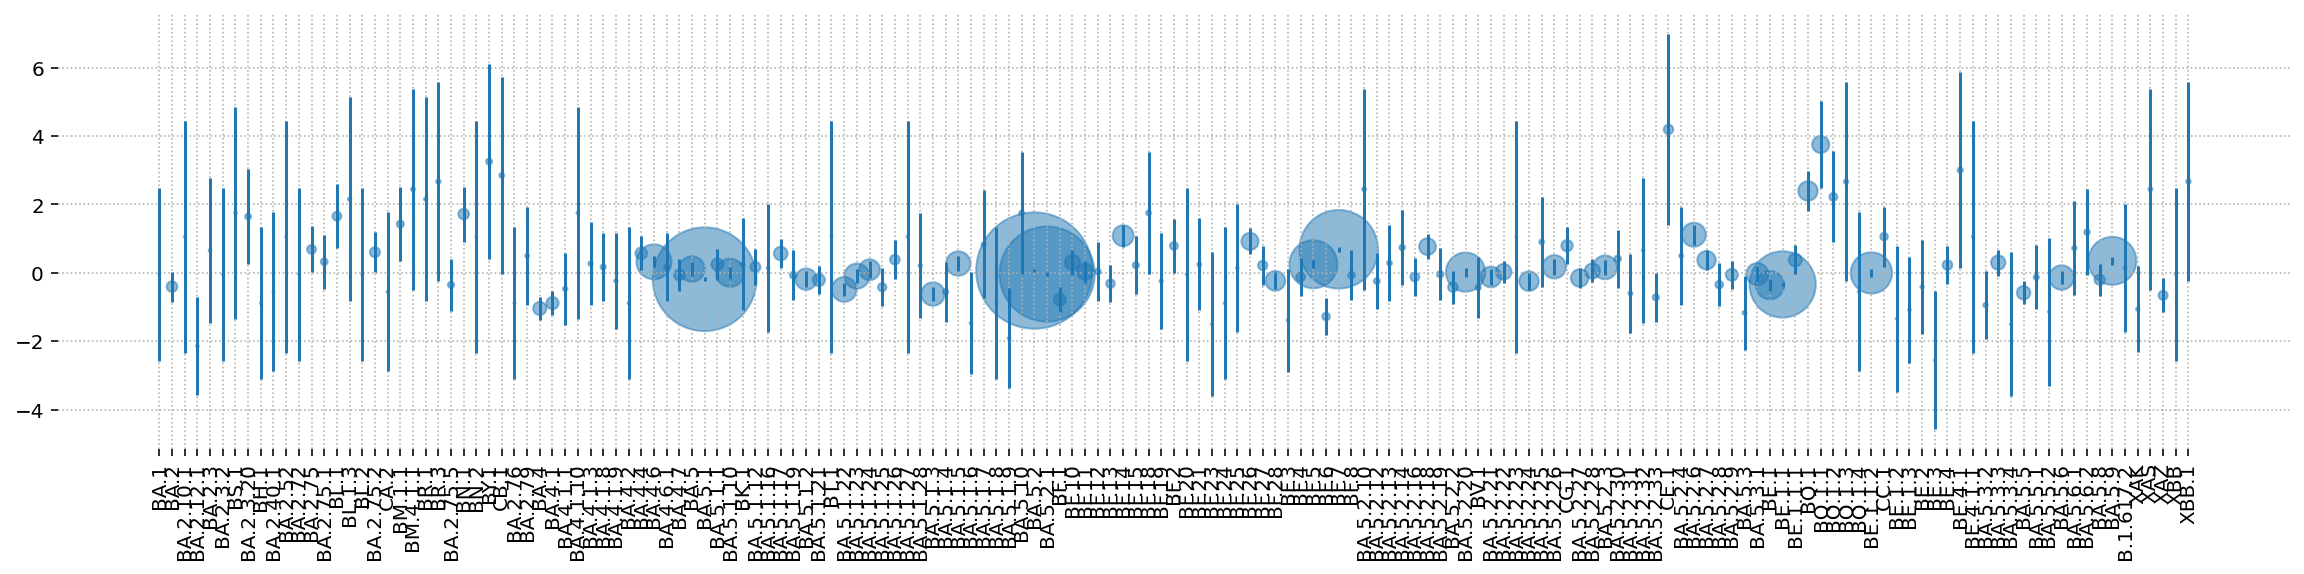

In [16]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(20,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
#plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

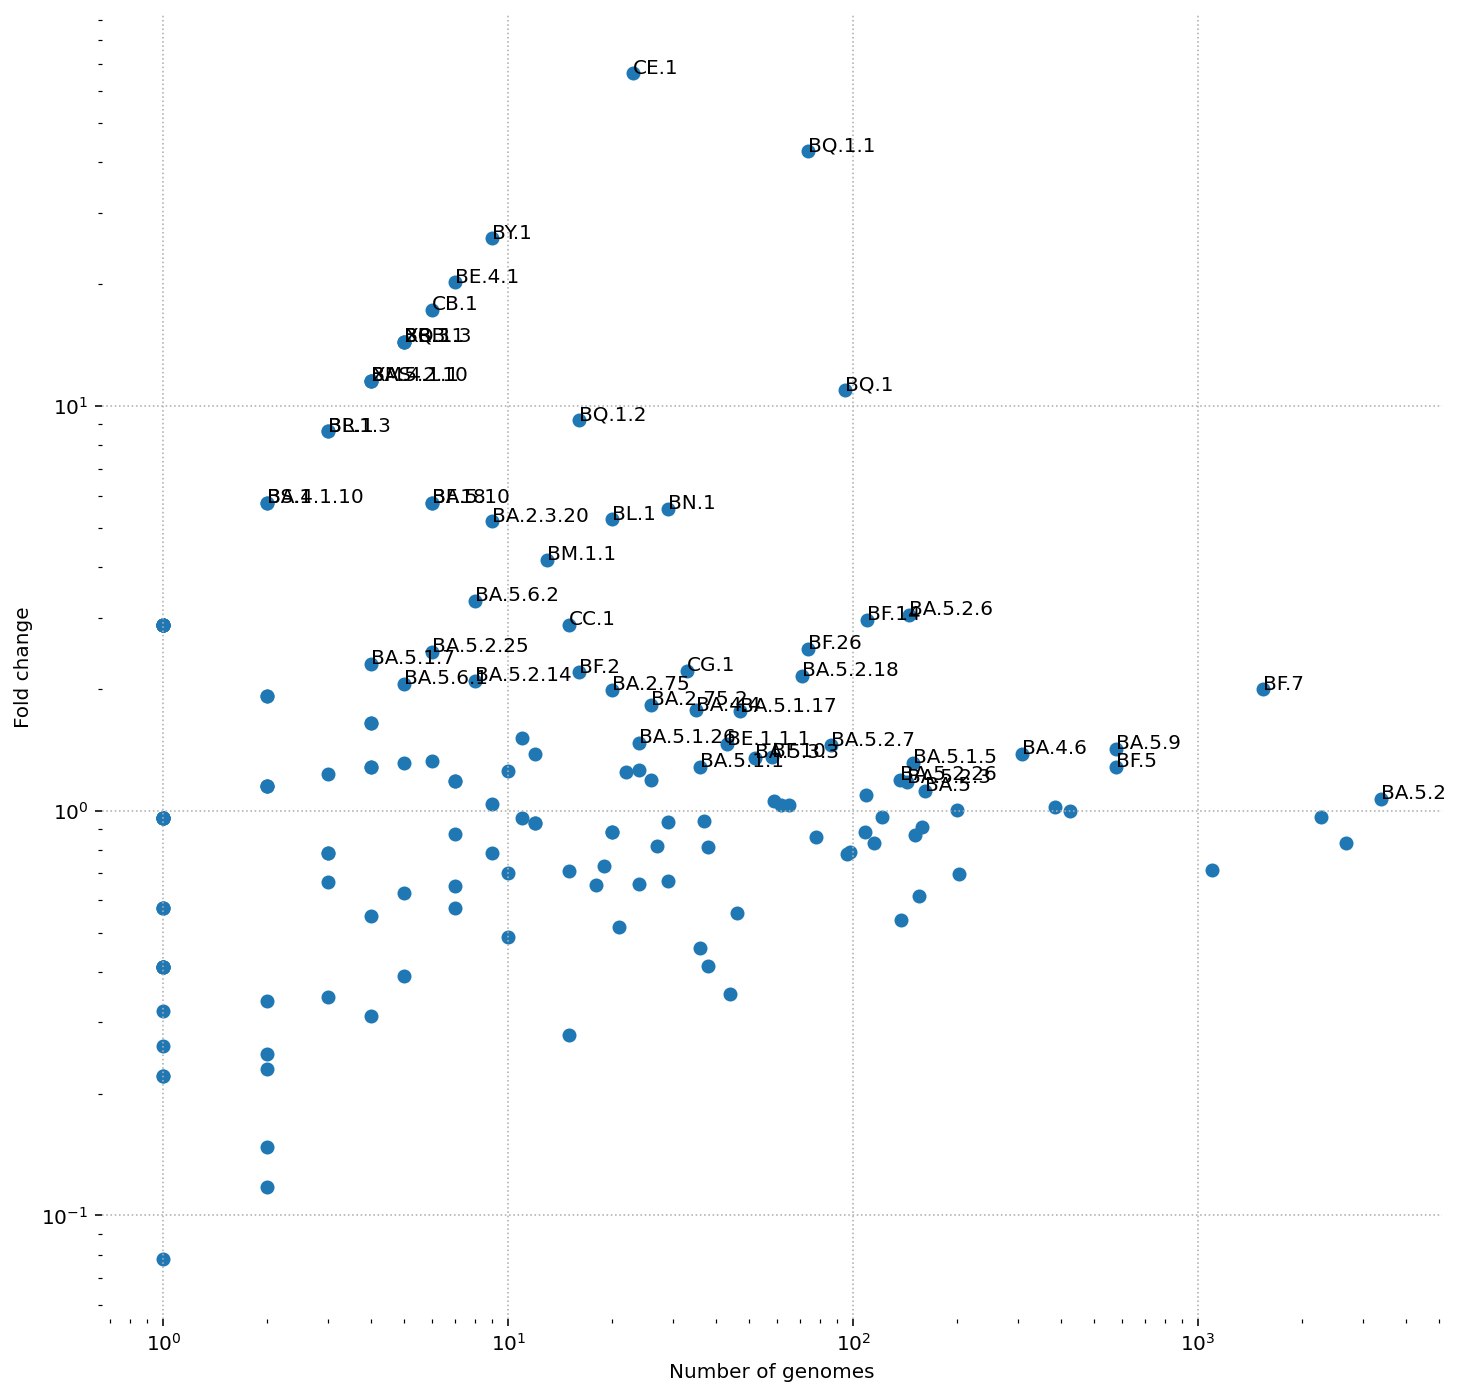

In [17]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19304.2)

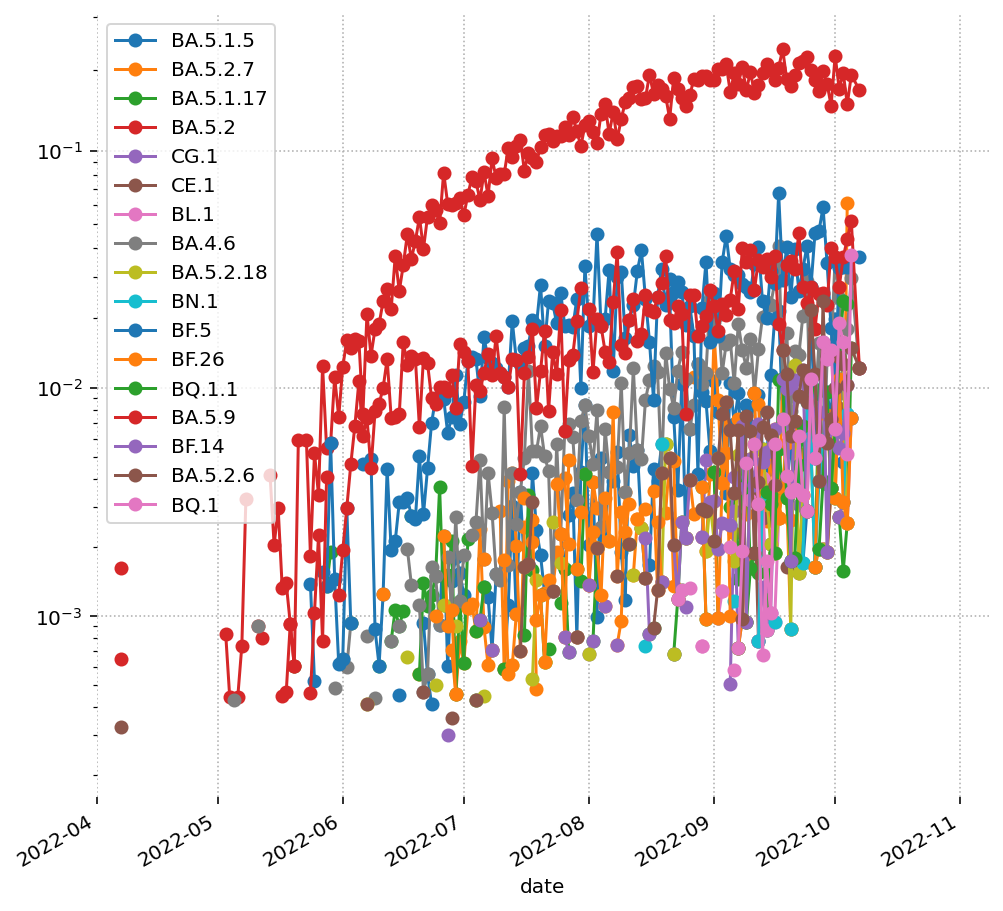

In [18]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [19]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

In [20]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [21]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         15
Bayern                     6
Berlin                     1
Brandenburg                2
Bremen                     0
Hamburg                    2
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              2
Nordrhein-Westfalen       13
Rheinland-Pfalz            1
Saarland                   1
Sachsen                    3
Sachsen-Anhalt             0
Schleswig-Holstein         4
Thüringen                  0
Name: BA.2.75, dtype: int64

#### Check old AY lineage growth

In [22]:
import importlib
importlib.reload(gs.utils)
importlib.reload(gs)
from genomicsurveillance.utils import preprocess_lineage_tensor

In [23]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [24]:
lineages = genomes.columns.to_list()

In [25]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 5), match='A.2.5'>

In [26]:
foo =d.lineage.value_counts()[:200]
bar = [d.date[d.lineage==l].sort_values()[10] for l in foo.index]
bak = pd.DataFrame({'counts':foo, 'date':bar})

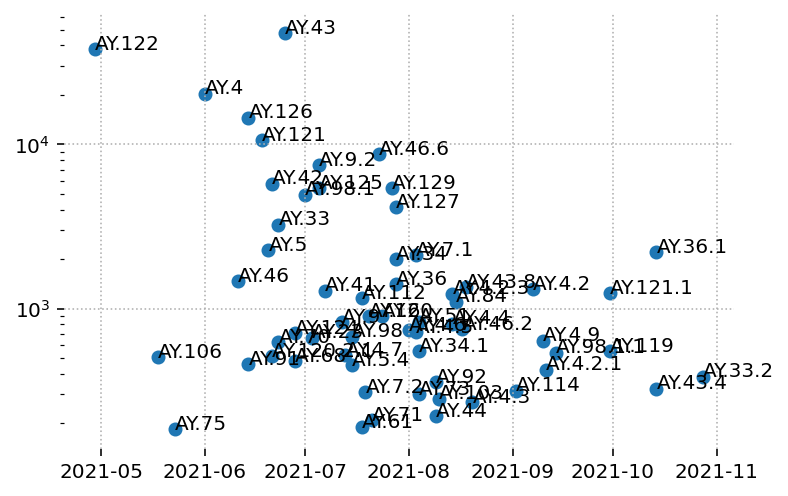

In [27]:
ay = bak.loc[bak.index.str.match('AY')]
plt.scatter(ay.date, ay.counts)
for i in ay.index:
    plt.text(bak.date[i], bak.counts[i], i)
plt.yscale('log')

### Assemble merged lineage array

In [28]:
alias("CE.1", anti_alias=True)

'B.1.1.529.5.2.33.1'

In [29]:
vocs = ["B.1.1.529","BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.2.12.1","BA.2.3.20","BA.2.75", "BA.2.75.1","BA.2.75.2","BN.1","BA.4.6", "BF.7", "BF.11", "BF.13", "BF.14","BQ.1","BQ.1.1"] + ["B.1.1.7","B.1.1.318","B.1.621","B.1.525","B.1.351","P.1","AY.43","AY.46.6","AY.4.2","AY.36.1"]

In [30]:
merged_lineages, G, _ = preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=100000)
merged_lineages

Dropped lineages []


['A',
 'B',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.3.20',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.2.75.5.1',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'XAB',
 'XAD',
 'XAF',
 'XAG',
 'XAH',
 'XAJ',
 'XAK',
 'XAL',
 'XAM',
 'XAN',
 'XAP',
 'XAS',
 'XAU',
 'XAV',
 'XAZ',
 'XB',
 'XBB',
 'XD',
 'XE',
 'XG',
 'XH',
 'XJ',
 'XM',
 'XV',
 'XW',
 'XZ']

In [31]:
G.sum((0,1))

array([6.93000e+02, 3.10830e+04, 9.77100e+04, 9.23000e+02, 1.17500e+03,
       5.47000e+02, 5.82770e+04, 1.08985e+05, 2.62370e+05, 1.10000e+01,
       3.91600e+03, 1.39000e+02, 6.70000e+01, 5.30000e+01, 3.60000e+01,
       6.53300e+03, 9.37000e+02, 7.84990e+04, 4.26300e+04, 3.11600e+03,
       2.09000e+02, 6.10000e+01, 1.69000e+02, 1.33000e+02, 7.60000e+01,
       1.97800e+03, 8.57000e+02, 1.75419e+05, 3.10200e+03, 2.21300e+03,
       4.91800e+04, 8.70800e+03, 1.65000e+02, 1.27000e+02, 9.10000e+01,
       2.00000e+00, 5.00000e+00, 5.00000e+00, 1.00000e+00, 1.28000e+02,
       9.80000e+01, 6.00000e+00, 2.80000e+01, 1.00000e+00, 1.70000e+01,
       6.00000e+00, 6.00000e+00, 2.53000e+02, 5.00000e+00, 7.00000e+00,
       1.00000e+00, 4.90000e+01, 4.60000e+01, 3.00000e+00, 1.00000e+00,
       3.77000e+02, 1.00000e+00, 5.30000e+01, 3.00000e+00])

In [32]:
baseline = 'B'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline and (not x.startswith("X") or x in vocs)] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['A',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.3.20',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.2.75.5.1',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'B']

In [33]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.3.20',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BN.1',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [34]:
dict(zip(merged_lineages_alias,G.sum((0,1))))

{'A': 693.0,
 'B.1.1.7': 97710.0,
 'P.1': 923.0,
 'B.1.1.318': 1175.0,
 'B.1.1.529': 547.0,
 'BA.1': 58277.0,
 'BA.1.1': 108985.0,
 'BA.2': 262370.0,
 'BA.2.3.20': 11.0,
 'BA.2.12.1': 3916.0,
 'BA.2.75': 139.0,
 'BA.2.75.1': 67.0,
 'BA.2.75.2': 53.0,
 'BN.1': 36.0,
 'BA.4': 6533.0,
 'BA.4.6': 937.0,
 'BA.5': 78499.0,
 'BA.5.2': 42630.0,
 'BF.7': 3116.0,
 'BF.11': 209.0,
 'BF.13': 61.0,
 'BF.14': 169.0,
 'BQ.1': 133.0,
 'BQ.1.1': 76.0,
 'B.1.351': 1978.0,
 'B.1.525': 857.0,
 'B.1.617.2': 175419.0,
 'AY.4.2': 3102.0,
 'AY.36.1': 2213.0,
 'AY.43': 49180.0,
 'AY.46.6': 8708.0,
 'B.1.621': 165.0,
 'B': 31083.0}

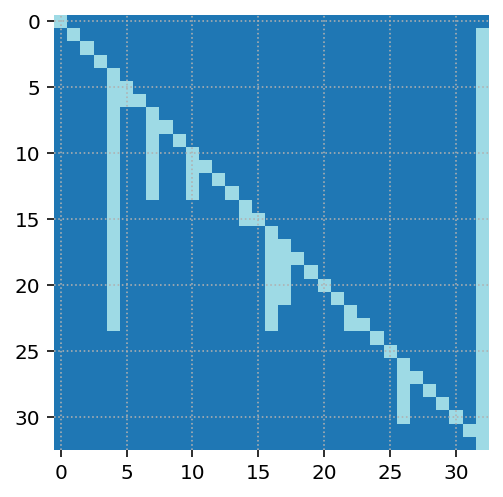

In [35]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

In [36]:
#A[1:-1,merged_lineages.index("B.1.1.7")] = 1
#A[merged_lineages.index('B.1.1.529'):-4,merged_lineages.index("B.1.617.2")] = 1
#plt.imshow(A)

### Cases
Also from RKI

In [37]:
cases_raw = pd.read_csv("https://github.com/robert-koch-institut/SARS-CoV-2-Infektionen_in_Deutschland/blob/main/Aktuell_Deutschland_SarsCov2_Infektionen.csv?raw=true",  index_col=[0,1,2,4], parse_dates=True)

In [38]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A35-A59      W          2022-10-11  2022-10-11   
            A60-A79      W          2022-10-11  2022-10-11   
            A15-A34      W          2022-10-12  2022-10-12   
            A35-A59      W          2022-10-12  2022-10-12   
            A60-A79      W          2022-10-12  2022-10-12   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A35-A59      W          2022-10-11                     0   
            A60-A79      W          2022-10-11                     0   
            A15-A34      W          2022-10-12                     0   
            A35-A59      W          2022-10-12                     0   
            A60-A79      W          2022-10-12                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A35-A59      W          2022-10-11          1              -9   
            A60-A79      W          2022-10-11          1              -9   
            A15-A34      W          2022-10-12          1              -9   
            A35-A59      W          2022-10-12          1              -9   
            A60-A79      W          2022-10-12          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A35-A59      W          2022-10-11          -9           4   
            A60-A79      W          2022-10-11          -9           2   
            A15-A34      W          2022-10-12          -9           3   
            A35-A59      W          2022-10-12          -9          17   
            A60-A79      W          2022-10-12          -9           3   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [39]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-08-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

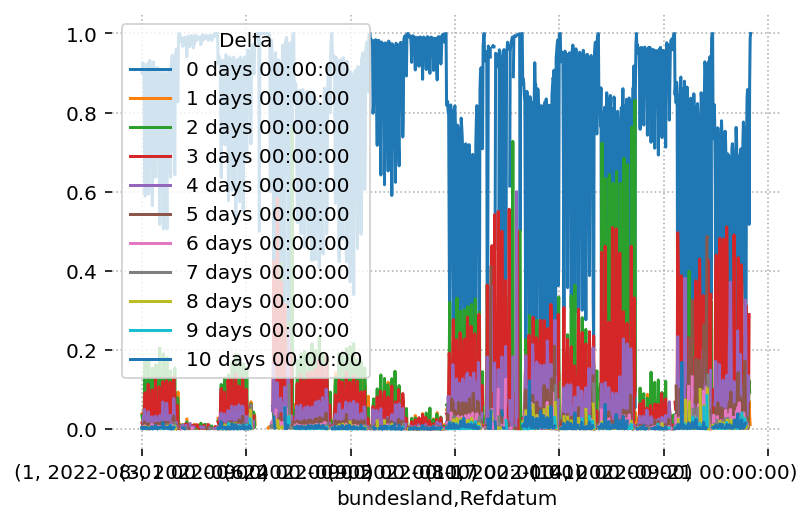

In [40]:
f.plot()

In [41]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [42]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [43]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Mon             0.885604         0.917706         0.960845         0.980424   
Tue             0.924941         0.952280         0.977519         0.988890   
Wed             0.922132         0.946876         0.975052         0.977886   
Thu             0.910362         0.943394         0.951493         0.958421   
Fri             0.904343         0.914668         0.928988         0.961261   
Sat             0.690208         0.727675         0.826005         0.932196   
Sun             0.611593         0.716682         0.872140         0.947970   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Mon             0.989006         0.990910         0.991263         0.996239   
Tue             0.990767         0.990931         0.995844         0.997505   
Wed             0.980038         0.991975         0.996262         0.997710   
Thu             0.981464         0.992202         0.995489         0.997700   
Fri             0.983544         0.992471         0.995138         0.997243   
Sat             0.975289         0.983692         0.990008         0.990035   
Sun             0.975238         0.987417         0.988344         0.989829   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Mon             0.998137         0.998916               1.0  
Tue             0.998935         0.999272               1.0  
Wed             0.998518         0.999315               1.0  
Thu             0.998628         0.998922               1.0  
Fri             0.998078         0.998532               1.0  
Sat             0.987535         0.993912               1.0  
Sun             0.994460         0.996051               1.0

In [44]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [45]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [46]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999790  0.999609  0.999278  0.998867  0.992611   
Bayern                  0.995631  0.992898  0.986985  0.974477  0.922765   
Berlin                  0.992261  0.985538  0.978757  0.964348  0.845296   
Brandenburg             0.998987  0.998489  0.995729  0.991810  0.945147   
Bremen                  0.998722  0.998971  0.993204  0.992666  0.966183   
Hamburg                 0.999227  1.000000  1.000000  1.000000  0.996614   
Hessen                  0.998663  0.998088  0.996204  0.994051  0.970232   
Mecklenburg-Vorpommern  0.997981  0.996911  0.993289  0.988181  0.878981   
Niedersachsen           0.998435  0.997887  0.996296  0.992605  0.969813   
Nordrhein-Westfalen     0.997033  0.995389  0.991962  0.986514  0.960440   
Rheinland-Pfalz         0.999550  0.999049  0.998849  0.997067  0.979020   
Saarland                1.000000  0.997858  0.998945  0.995507  0.837879   
Sachsen                 0.999503  0.998540  0.998244  0.996685  0.985620   
Sachsen-Anhalt          0.997701  0.994584  0.988350  0.970313  0.769961   
Schleswig-Holstein      0.998935  0.997710  0.995489  0.992471  0.975289   
Thüringen               0.993017  0.989545  0.983008  0.967356  0.890984   

                               5         6         7         8  
Baden-Württemberg       0.984311  0.994668  0.994526  0.992051  
Bayern                  0.839578  0.871839  0.845354  0.791716  
Berlin                  0.683630  0.862556  0.882335  0.868954  
Brandenburg             0.835251  0.923110  0.964591  0.953730  
Bremen                  0.834456  0.891921  0.964270  0.980383  
Hamburg                 0.995105  0.996033  0.995518  0.993041  
Hessen                  0.915724  0.967570  0.950643  0.933919  
Mecklenburg-Vorpommern  0.917997  0.928584  0.860897  0.808755  
Niedersachsen           0.927391  0.964520  0.964590  0.946855  
Nordrhein-Westfalen     0.906280  0.925942  0.907730  0.864790  
Rheinland-Pfalz         0.939354  0.985076  0.986149  0.978786  
Saarland                0.889516  0.879854  0.973367  0.968678  
Sachsen                 0.953947  0.984470  0.980674  0.963848  
Sachsen-Anhalt          0.661853  0.818523  0.886103  0.862153  
Schleswig-Holstein      0.947970  0.960845  0.952280  0.922132  
Thüringen               0.796038  0.795664  0.756232  0.781191

In [47]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [48]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,start_date:,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-01-01  2021-01-02  2021-01-03  2021-01-04  \
bundesland                                                               
Baden-Württemberg             1586        1666        1663        2042   
Bayern                        2152        2446        2221        2910   
Berlin                         595         687         687        1006   
Brandenburg                    647         529         542        1095   
Bremen                          30          48          46          55   
Hamburg                        328         375         361         484   
Hessen                        1084         919         959        1174   
Mecklenburg-Vorpommern         178         218         271         485   
Niedersachsen                  874         956         957        1287   
Nordrhein-Westfalen           2264        2600        2552        3695   
Rheinland-Pfalz                541         680         480         712   
Saarland                       144         116         154         233   
Sachsen                       1371        1489        1447        2031   
Sachsen-Anhalt                 691         651         600         782   
Schleswig-Holstein             298         346         318         371   
Thüringen                      615         702         805         923   

Refdatum                2021-01-05  2021-01-06  2021-01-07  2021-01-08  \
bundesland                                                               
Baden-Württemberg             2554        1964        2065        2250   
Bayern                        3600        3026        3271        3585   
Berlin                         981        1008         992         986   
Brandenburg                   1196        1092        1055         907   
Bremen                          81          96         102          81   
Hamburg                        426         379         392         343   
Hessen                        1533        1719        1409        1361   
Mecklenburg-Vorpommern         269         295         221         255   
Niedersachsen                 1505        1649        1300        1312   
Nordrhein-Westfalen           3985        4428        3815        3699   
Rheinland-Pfalz                843         923        1015         903   
Saarland                       242         316         284         241   
Sachsen                       2507        2389        2056        1994   
Sachsen-Anhalt                 802         700         955         866   
Schleswig-Holstein             413         396         392         414   
Thüringen                     1017         922         887        1070   

Refdatum                2021-01-09  2021-01-10  ...  2022-10-03  2022-10-04  \
bundesland                                      ...                           
Baden-Württemberg             1800        1381  ...        2271       15877   
Bayern                        2642        1930  ...        5561       25402   
Berlin                         554         461  ...         312        3740   
Brandenburg                    752         651  ...         281        3023   
Bremen                          83          43  ...          63        1234   
Hamburg                        237         295  ...         437         927   
Hessen                        1132         782  ...        1740       12351   
Mecklenburg-Vorpommern         192         289  ...         722        2513   
Niedersachsen                 1189         731  ...        1519       11924   
Nordrhein-Westfalen           2760        2163  ...        5651       20191   
Rheinland-Pfalz                662         419  ...         658        7722   
Saarland                       228         104  ...           8        2839   
Sachsen                       1235         881  ...         932        5617   
Sachsen-Anhalt                 536         505  ...         353        2756   
Schleswig-Holstein             378         294  ...         733       

In [49]:
cases_land.sum(0)

Refdatum
2021-01-01     13398
2021-01-02     14428
2021-01-03     14063
2021-01-04     19285
2021-01-05     21954
               ...  
2022-10-08     26645
2022-10-09     18183
2022-10-10    132694
2022-10-11    126576
2022-10-12     84929
Length: 650, dtype: int64

In [50]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-01-01  2021-01-02  2021-01-03  2021-01-04  \
bundesland                                                               
Baden-Württemberg             1586        1666        1663        2042   
Bayern                        2152        2446        2221        2910   
Berlin                         595         687         687        1006   
Brandenburg                    647         529         542        1095   
Bremen                          30          48          46          55   
Hamburg                        328         375         361         484   
Hessen                        1084         919         959        1174   
Mecklenburg-Vorpommern         178         218         271         485   
Niedersachsen                  874         956         957        1287   
Nordrhein-Westfalen           2264        2600        2552        3695   
Rheinland-Pfalz                541         680         480         712   
Saarland                       144         116         154         233   
Sachsen                       1371        1489        1447        2031   
Sachsen-Anhalt                 691         651         600         782   
Schleswig-Holstein             298         346         318         371   
Thüringen                      615         702         805         923   

Refdatum                2021-01-05  2021-01-06  2021-01-07  2021-01-08  \
bundesland                                                               
Baden-Württemberg             2554        1964        2065        2250   
Bayern                        3600        3026        3271        3585   
Berlin                         981        1008         992         986   
Brandenburg                   1196        1092        1055         907   
Bremen                          81          96         102          81   
Hamburg                        426         379         392         343   
Hessen                        1533        1719        1409        1361   
Mecklenburg-Vorpommern         269         295         221         255   
Niedersachsen                 1505        1649        1300        1312   
Nordrhein-Westfalen           3985        4428        3815        3699   
Rheinland-Pfalz                843         923        1015         903   
Saarland                       242         316         284         241   
Sachsen                       2507        2389        2056        1994   
Sachsen-Anhalt                 802         700         955         866   
Schleswig-Holstein             413         396         392         414   
Thüringen                     1017         922         887        1070   

Refdatum                2021-01-09  2021-01-10  ...  2022-10-01  2022-10-02  \
bundesland                                      ...                           
Baden-Württemberg             1800        1381  ...        2271        1464   
Bayern                        2642        1930  ...        7843        5012   
Berlin                         554         461  ...         277         270   
Brandenburg                    752         651  ...         380         239   
Bremen                          83          43  ...         121          95   
Hamburg                        237         295  ...         342         510   
Hessen                        1132         782  ...        2441        1322   
Mecklenburg-Vorpommern         192         289  ...         375         264   
Niedersachsen                 1189         731  ...        2549        1524   
Nordrhein-Westfalen           2760        2163  ...        6611        4914   
Rheinland-Pfalz                662         419  ...         764         504   
Saarland                       228         104  ...           5          66   
Sachsen                       1235         881  ...         988         452   
Sachsen-Anhalt                 536         505  ...         582         326   
Schleswig-Holstein             378         294  ...         677       

In [51]:
C = cases_land.values

### Population data
From Destatis

In [52]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [53]:
131 % 10

1

## Modeling
### Basis functions

In [54]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [55]:
B0.shape

(2, 650, 68)

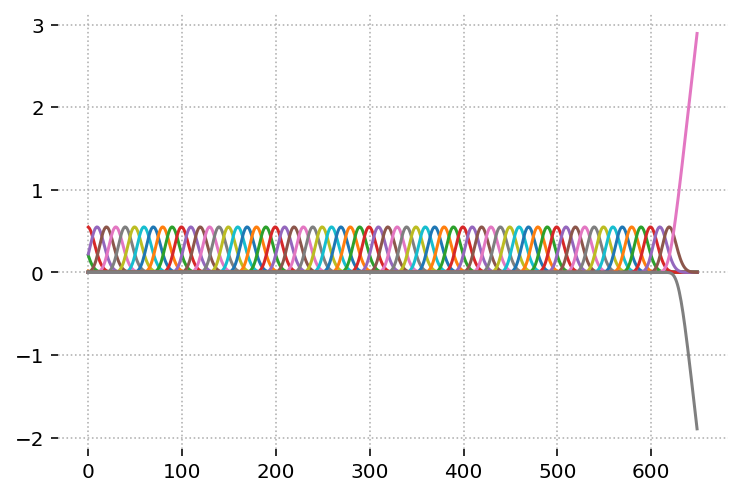

In [56]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

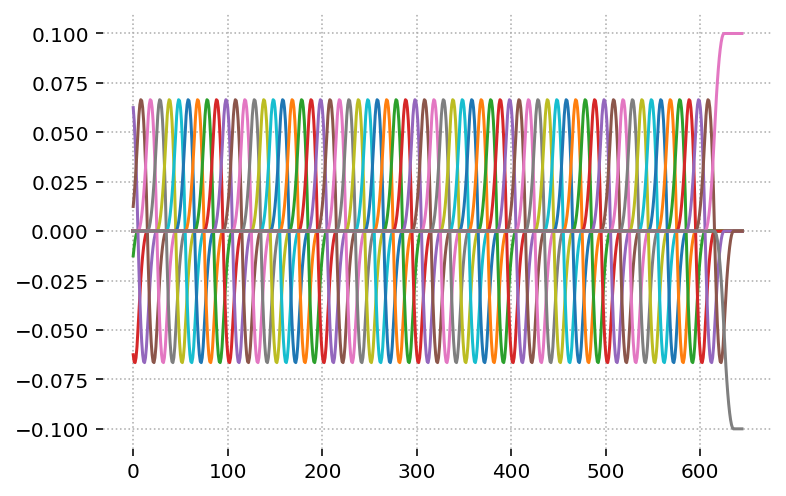

In [57]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [58]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

14

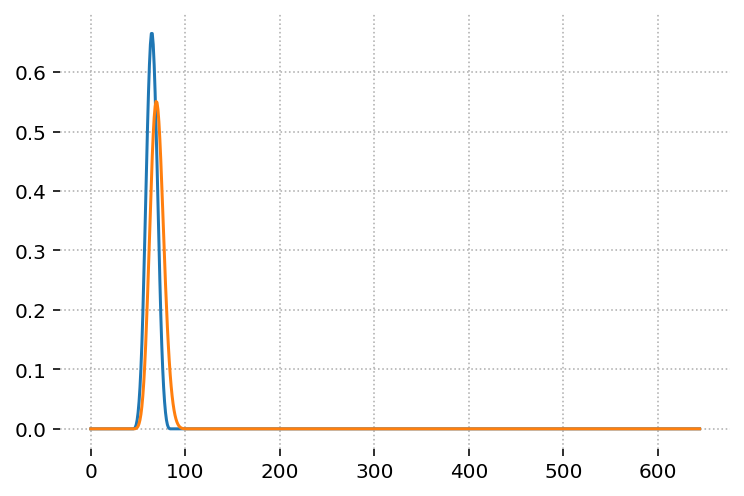

In [59]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


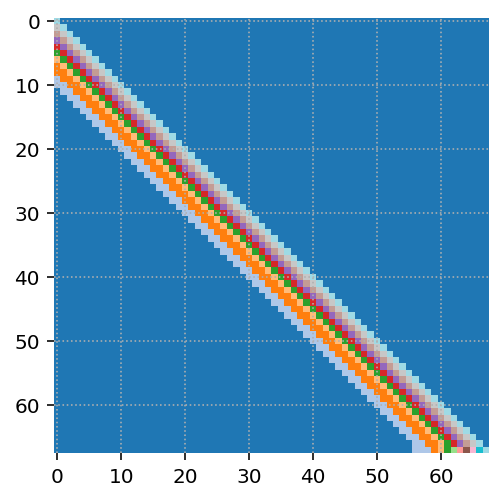

In [60]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [61]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [62]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [63]:
from numpyro.infer import Trace_ELBO

In [64]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)
#CC[-1, -2:] = np.nan #cases_land.columns.to_list().index(np.datetime64("2022-10-03"))

In [65]:
CC[-1, -14:]

array([ 95424.        ,  87641.        ,  75020.        ,  72294.        ,
        26734.        ,  18110.        ,  21939.        , 122272.70384943,
       141321.50383285, 135176.81893377, 110815.61443283,  27954.33058701,
        20514.32073604, 142798.94190966])

In [66]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0
GG[:, genomes.index.levels[1] < "2022-02-01", merged_lineages_alias.index("BA.5")] = 0 # Some erroneous BA.5
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.1.7")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.351")] = 0 # Issues with spurious B lineages later on
GG[:, (genomes.index.levels[1] < "2021-11-01").reshape(-1,1) * np.array([x.startswith("B.1.1.529") for x in merged_lineages]).reshape(1,-1)] = 0
GG[:, (genomes.index.levels[1] < "2021-04-01").reshape(-1,1) * np.array([x.startswith("B.1.617.2") for x in merged_lineages]).reshape(1,-1)] = 0

In [67]:
#GG[:, genomes.index.levels[1] >= "2022-09-23"] = 0 ## Currently few data from covspectrum

# Genomic surveillance analysis in Germany

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [68]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=5,
    c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=True,#True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.03, 'lrd': 0.5 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [69]:
model.fit(num_epochs=200)

SVI step 0 / 200 | 0 %


Text(0, 0.5, 'ELBO')

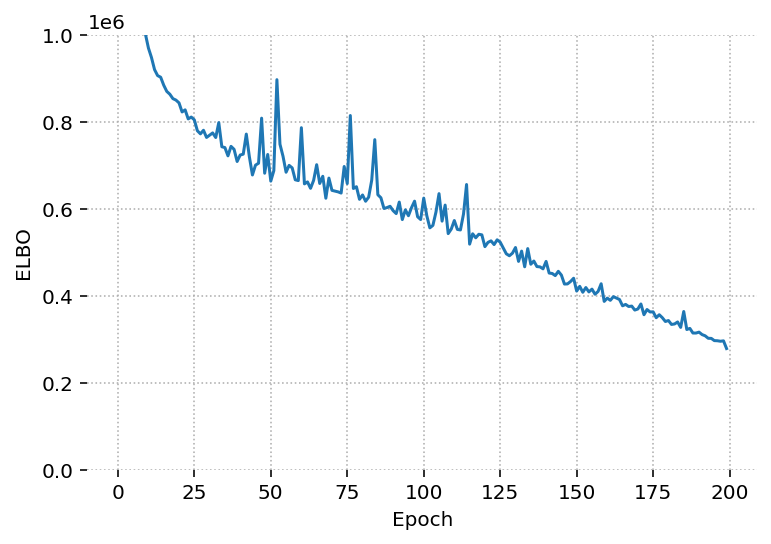

In [70]:
plt.plot(model.loss)
plt.ylim((0,1e6))
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [71]:
model.fit(num_epochs=400)

SVI step 0 / 400 | 0 %
SVI step 200 / 400 | 50 %


Text(0, 0.5, 'ELBO')

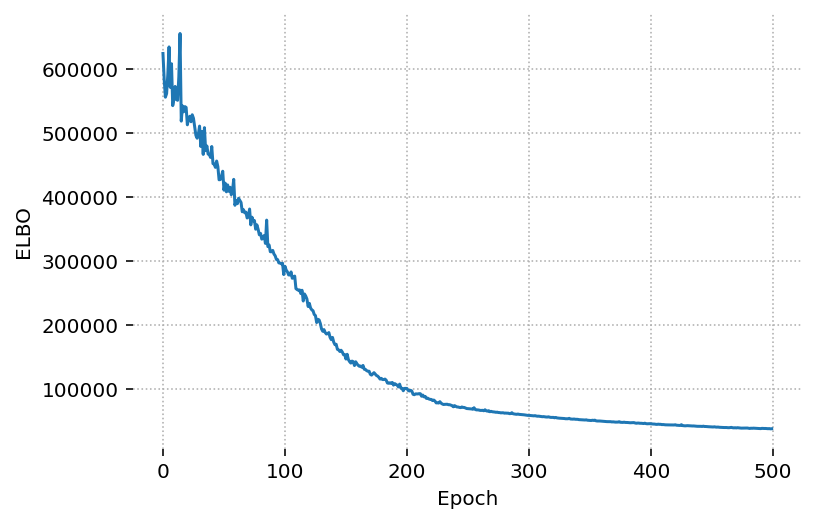

In [72]:
plt.plot(model.loss[100:])
#plt.ylim((0,1e6))
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [73]:
model.fit(num_epochs=2000)

SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

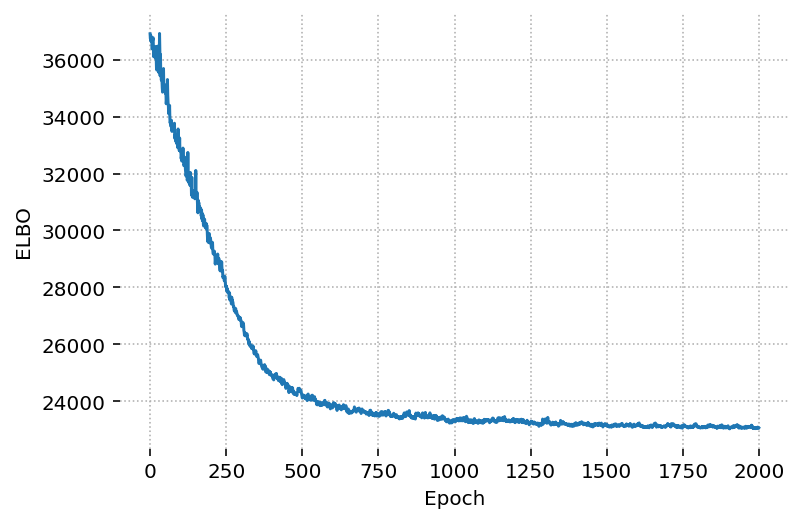

In [74]:
plt.plot(model.loss[-2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [75]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                  'BA.2.3.20':'orange',
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                   'BN.1':"tomato",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                   'BQ.1':'aquamarine',
                  'BQ.1.1':'mediumspringgreen',
                 #'Other':"C7",
                 'B.1.617.2': 'C0',
                 'AY.4.2': 'lightblue',
                  'AY.36.1': 'steelblue',
                  'AY.43': 'skyblue',
                  'AY.46.6': 'lightsteelblue',
                  'A': 'lightgrey',
                  'B': 'lightgrey',
                  'B.1.1.7': 'navy' ,
                  'B.1.351': 'black',
                  'P.1' : 'slategrey',
                  'B.1.525':'C7',
                  'B.1.1.318': 'grey',
                  'B.1.621':'grey'
                 } #"aliceblue"}

In [76]:
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.3.20',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BN.1',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [77]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

In [78]:
escape_lineages = [x for x in merged_lineages_alias if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ","BN","BA.2.3.20"]), x)]

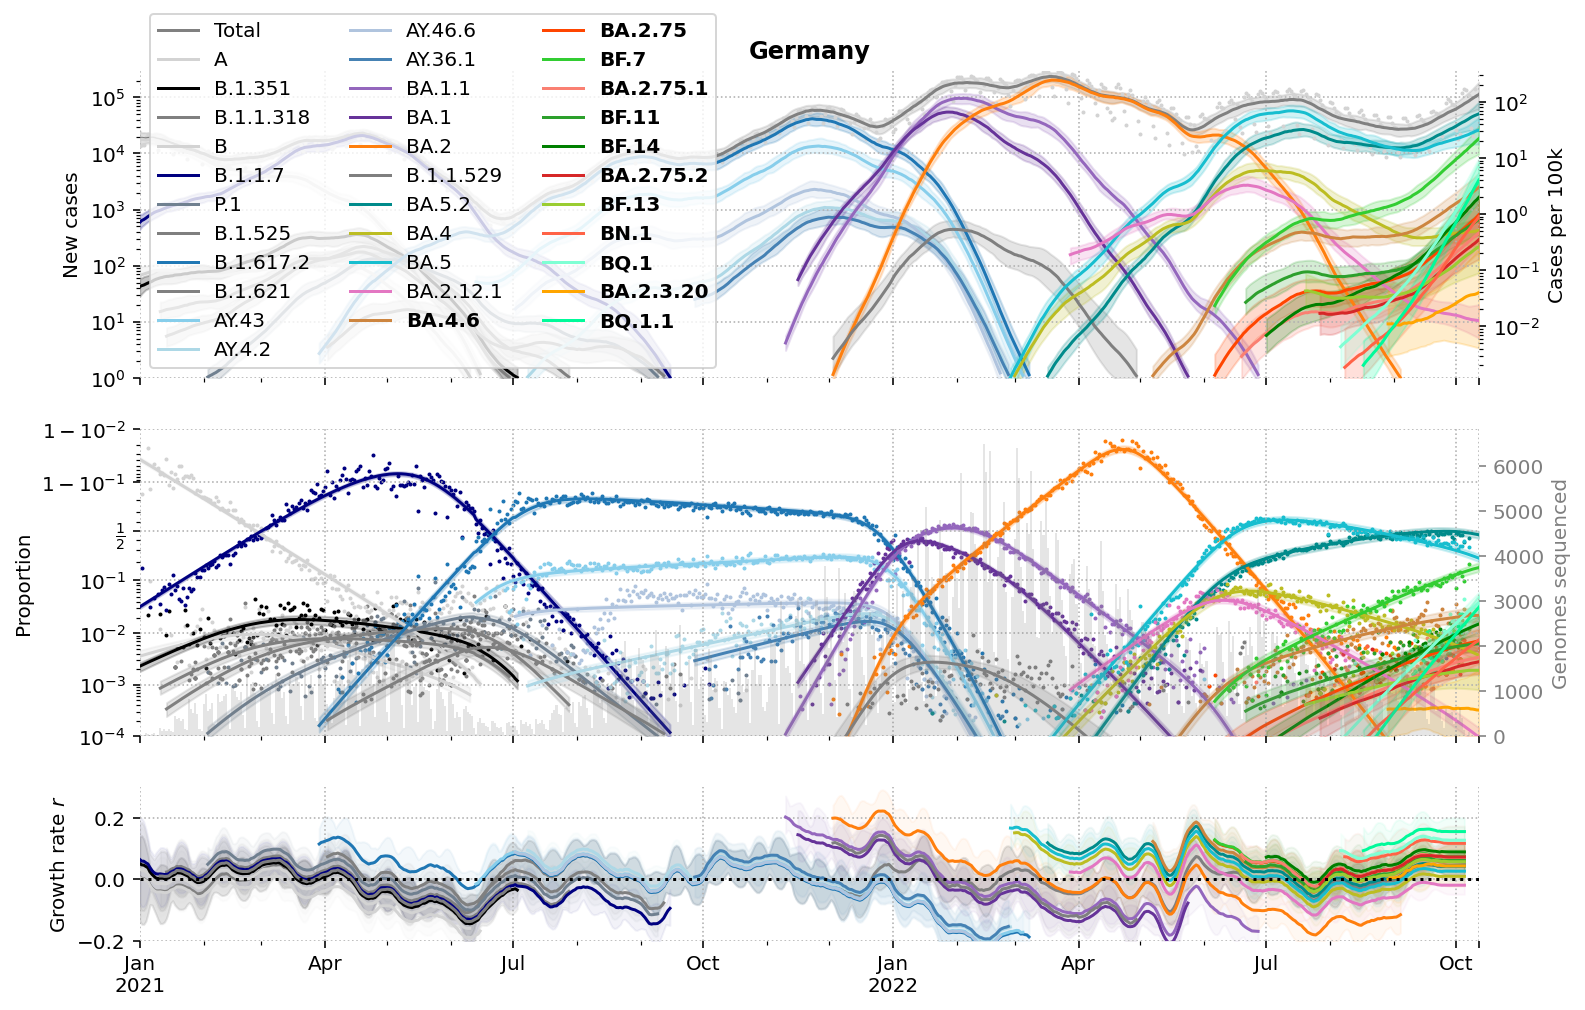

In [79]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
x = (GG[-1].cumsum(0)>0).argmax(0)
o = np.argsort(x + np.argsort(merged_lineages))
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = o#np.where(GG[i].sum(0) >= 3)[0]
    #w = list(set(w) - set([0,GG.shape[2]-2]))
    #w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date=start_date, show_start_date=start_date,
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(12,8),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    #ax[2].set_xlim(("2022-06-01",None))
    #ax[0].legend("off")
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=3)
    for l in leg.get_texts():
        if l.get_text() in escape_lineages:
            l.set_weight('bold')
    #plt.gcf().set_size_inches(12,12)

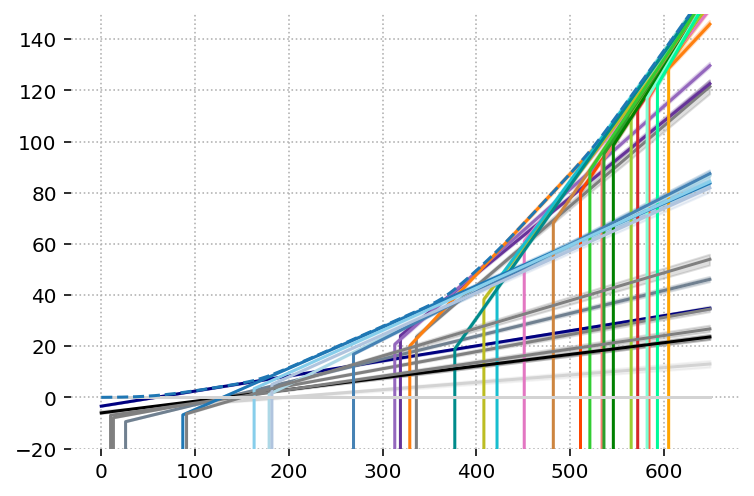

In [80]:
l = model.get_logits(ltla=-1).squeeze()
#l -= logsumexp(l.mean(0),-1)[...,np.newaxis]
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(l.shape[-1]):
    plt.plot(np.median(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,150))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1), ls="--")


#plt.plot(np.max(np.mean(l,0),-1))

In [81]:
lse = logsumexp(l.mean(0).squeeze(), -1)
t0 = 100
y =lse[-t0:] - (lse[-t0]-lse[-t0-1])*np.arange(t0) - lse[-t0]
#plt.plot(np.diff(y))
#plt.plot(l.mean(0).squeeze().max(-1))

In [82]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

In [83]:
r.T - r['AY.4.2']

Germany
A         -0.153159
B.1.1.7   -0.122920
P.1       -0.092609
B.1.1.318 -0.115166
B.1.1.529  0.130810
BA.1       0.117191
BA.1.1     0.142638
BA.2       0.211399
BA.2.3.20  0.336643
BA.2.12.1  0.276194
BA.2.75    0.367364
BA.2.75.1  0.368157
BA.2.75.2  0.366800
BN.1       0.414743
BA.4       0.303942
BA.4.6     0.351350
BA.5       0.321154
BA.5.2     0.337460
BF.7       0.369233
BF.11      0.355526
BF.13      0.351344
BF.14      0.383280
BQ.1       0.425798
BQ.1.1     0.450663
B.1.351   -0.136077
B.1.525   -0.129040
B.1.617.2 -0.020972
AY.4.2     0.000000
AY.36.1    0.003705
AY.43     -0.015592
AY.46.6   -0.017382
B.1.621   -0.074174
B         -0.181882

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 [Text(1, 0, 'A'),
  Text(2, 0, 'B.1.1.7'),
  Text(3, 0, 'P.1'),
  Text(4, 0, 'B.1.1.318'),
  Text(5, 0, 'B.1.1.529'),
  Text(6, 0, 'BA.1'),
  Text(7, 0, 'BA.1.1'),
  Text(8, 0, 'BA.2'),
  Text(9, 0, 'BA.2.3.20'),
  Text(10, 0, 'BA.2.12.1'),
  Text(11, 0, 'BA.2.75'),
  Text(12, 0, 'BA.2.75.1'),
  Text(13, 0, 'BA.2.75.2'),
  Text(14, 0, 'BN.1'),
  Text(15, 0, 'BA.4'),
  Text(16, 0, 'BA.4.6'),
  Text(17, 0, 'BA.5'),
  Text(18, 0, 'BA.5.2'),
  Text(19, 0, 'BF.7'),
  Text(20, 0, 'BF.11'),
  Text(21, 0, 'BF.13'),
  Text(22, 0, 'BF.14'),
  Text(23, 0, 'BQ.1'),
  Text(24, 0, 'BQ.1.1'),
  Text(25, 0, 'B.1.351'),
  Text(26, 0, 'B.1.525'),
  Text(27, 0, 'B.1.617.2'),
  Text(28, 0, 'AY.4.2'),
  Text(29, 0, 'AY.36.1'),
  Text(30, 0, 'AY.43'),
  Text(31, 0, 'AY.46.6'),
  Text(32, 0, 'B.1.621'),
  Text(33, 0, 'B')])

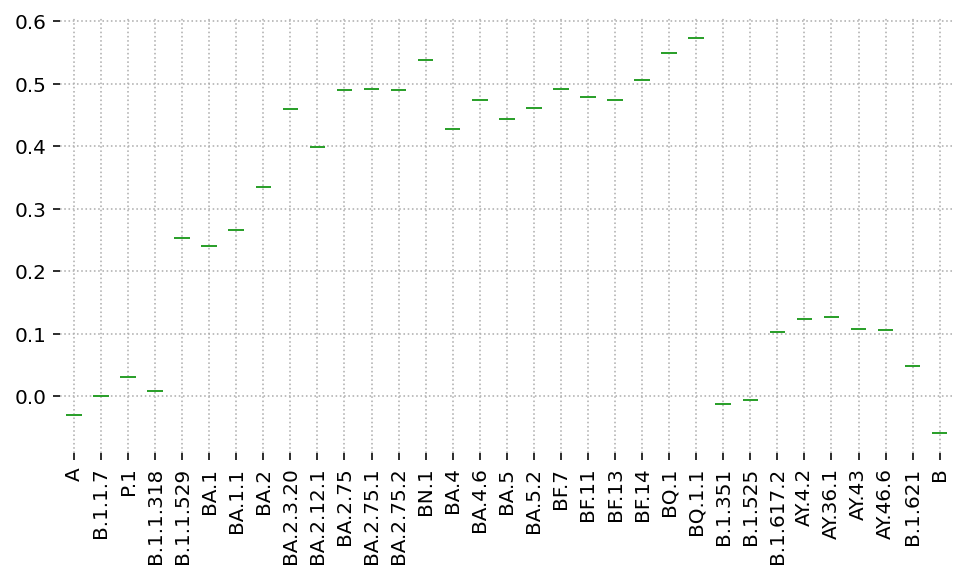

In [84]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [85]:
import re

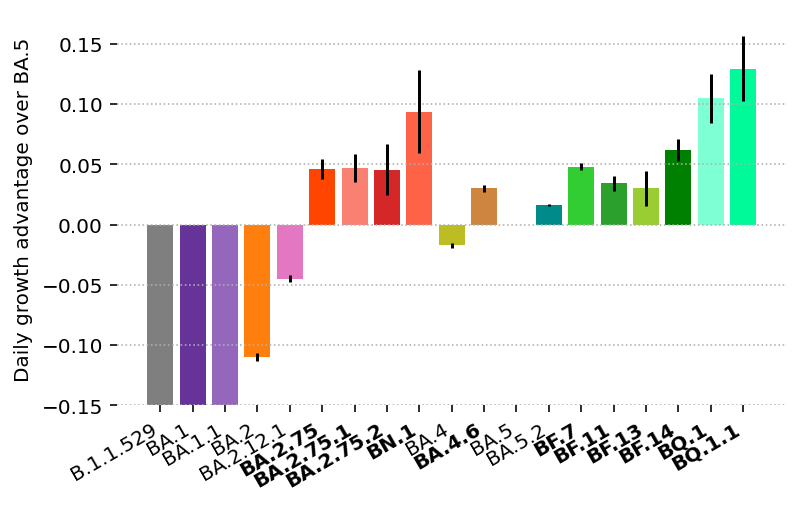

[Text(0, 0, 'B.1.1.529'), Text(1, 0, 'BA.1'), Text(2, 0, 'BA.1.1'), Text(3, 0, 'BA.2'), Text(4, 0, 'BA.2.12.1'), Text(5, 0, 'BA.2.75'), Text(6, 0, 'BA.2.75.1'), Text(7, 0, 'BA.2.75.2'), Text(8, 0, 'BN.1'), Text(9, 0, 'BA.4'), Text(10, 0, 'BA.4.6'), Text(11, 0, 'BA.5'), Text(12, 0, 'BA.5.2'), Text(13, 0, 'BF.7'), Text(14, 0, 'BF.11'), Text(15, 0, 'BF.13'), Text(16, 0, 'BF.14'), Text(17, 0, 'BQ.1'), Text(18, 0, 'BQ.1.1')]


In [86]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias)[[x for x in merged_lineages_alias if alias(x, anti_alias=True).startswith("B.1.1.529")]].drop(columns="BA.2.3.20")
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if l.get_text() in escape_lineages:
        l.set_weight('bold')
plt.show()
print(xl)

In [87]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias).T

0.025         0.500         0.975
A          0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.7    0.000000e+00  0.000000e+00  0.000000e+00
P.1        0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.318  0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.529  2.149317e-19  7.099535e-18  1.300352e-16
BA.1       1.049465e-17  2.486344e-17  4.686697e-17
BA.1.1     1.351011e-14  2.740776e-14  5.833777e-14
BA.2       1.878177e-07  3.036144e-07  4.620238e-07
BA.2.3.20  3.324992e-05  3.200642e-04  1.976101e-03
BA.2.12.1  6.530674e-05  9.472321e-05  1.443300e-04
BA.2.75    4.728814e-03  7.170586e-03  1.209309e-02
BA.2.75.1  1.700905e-03  3.447760e-03  6.485506e-03
BA.2.75.2  1.592044e-03  2.804451e-03  6.874739e-03
BN.1       2.611954e-03  7.432291e-03  2.131533e-02
BA.4       2.883349e-03  3.756337e-03  5.001489e-03
BA.4.6     1.682241e-02  2.224651e-02  3.165509e-02
BA.5       2.015799e-01  2.288454e-01  2.609006e-01
BA.5.2     4.197197e-01  4.593067e-01  4.971867e-01
BF.7       1.394383e-01  1.628028e-01  1.939584e-01
BF.11      4.447734e-03  6.285493e-03  9.322265e-03
BF.13      7.972844e-04  1.910077e-03  3.790719e-03
BF.14      1.026690e-02  1.509802e-02  2.177726e-02
BQ.1       2.392295e-02  3.883413e-02  5.977921e-02
BQ.1.1     1.780167e-02  3.171790e-02  5.372582e-02
B.1.351    0.000000e+00  0.000000e+00  0.000000e+00
B.1.525    0.000000e+00  0.000000e+00  0.000000e+00
B.1.617.2  5.789038e-35  2.329438e-34  1.022488e-33
AY.4.2     1.161707e-33  5.581908e-33  1.952258e-32
AY.36.1    3.348221e-33  1.046508e-32  3.905446e-32
AY.43      1.151887e-34  4.458989e-34  1.574676e-33
AY.46.6    1.224245e-35  4.192845e-35  1.567345e-34
B.1.621    0.000000e+00  0.000000e+00  0.000000e+00
B          0.000000e+00  0.000000e+00  0.000000e+00

In [88]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [89]:
λ.shape

(1, 650, 33)

In [90]:
from genomicsurveillance.misc import get_transmissibility

In [91]:
GG.shape

(17, 644, 33)

In [92]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

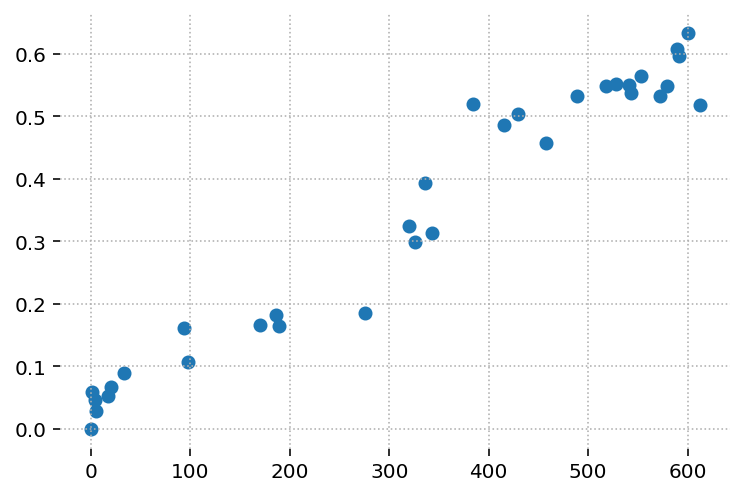

In [93]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [94]:
x = (GG[-1].cumsum(0)>0).argmax(0)
y = (-GG[-1]).cumsum(0).argmin(0)
dict(zip(merged_lineages_alias, genomes.index.levels[1][y]))

{'A': Timestamp('2021-06-21 00:00:00'),
 'B.1.1.7': Timestamp('2021-10-04 00:00:00'),
 'P.1': Timestamp('2021-10-22 00:00:00'),
 'B.1.1.318': Timestamp('2022-03-24 00:00:00'),
 'B.1.1.529': Timestamp('2022-06-21 00:00:00'),
 'BA.1': Timestamp('2022-09-09 00:00:00'),
 'BA.1.1': Timestamp('2022-07-21 00:00:00'),
 'BA.2': Timestamp('2022-10-03 00:00:00'),
 'BA.2.3.20': Timestamp('2022-09-29 00:00:00'),
 'BA.2.12.1': Timestamp('2022-09-19 00:00:00'),
 'BA.2.75': Timestamp('2022-10-07 00:00:00'),
 'BA.2.75.1': Timestamp('2022-10-05 00:00:00'),
 'BA.2.75.2': Timestamp('2022-10-03 00:00:00'),
 'BN.1': Timestamp('2022-10-05 00:00:00'),
 'BA.4': Timestamp('2022-10-07 00:00:00'),
 'BA.4.6': Timestamp('2022-10-07 00:00:00'),
 'BA.5': Timestamp('2022-10-07 00:00:00'),
 'BA.5.2': Timestamp('2022-10-07 00:00:00'),
 'BF.7': Timestamp('2022-10-07 00:00:00'),
 'BF.11': Timestamp('2022-10-04 00:00:00'),
 'BF.13': Timestamp('2022-09-29 00:00:00'),
 'BF.14': Timestamp('2022-10-04 00:00:00'),
 'BQ.1': Time

In [95]:
ll = model.get_logits()
ll = np.concatenate([ll, ll[:,:,[-1],:] + np.arange(1,90).reshape((1,1,-1,1)) * model.posterior['b1']], axis=2)

In [96]:
from scipy.special import softmax
pp = softmax(ll, axis=-1)

In [97]:
f = np.einsum("...l,...l", pp, b).squeeze()

In [98]:
r = b.squeeze()
from adjustText import adjust_text

In [99]:
r.shape

(100, 33)

In [100]:
f.shape

(100, 739)

In [101]:
r0 = model.get_growth_rate().squeeze()

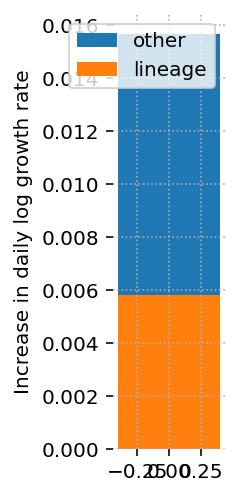

In [102]:
plt.figure(figsize=(1,4))
plt.bar(x=0,height=(r0[:,-1]-r0[:,-29]).mean(0), bottom=(f[:,-1]-f[:,-29]).mean(0), label='other') 
plt.bar(x=0 , height=(f[:,-1]-f[:,-29]).mean(0), label='lineage')
plt.ylabel("Increase in daily log growth rate")
plt.legend()

In [103]:
 cases_land.columns

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04',
               '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08',
               '2022-10-09', '2022-10-10'],
              dtype='datetime64[ns]', name='Refdatum', length=648, freq=None)

In [104]:
f.shape

(100, 739)

In [105]:
import matplotlib.pyplot as plt

In [106]:
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/matplotlib/pyplot.py'>

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


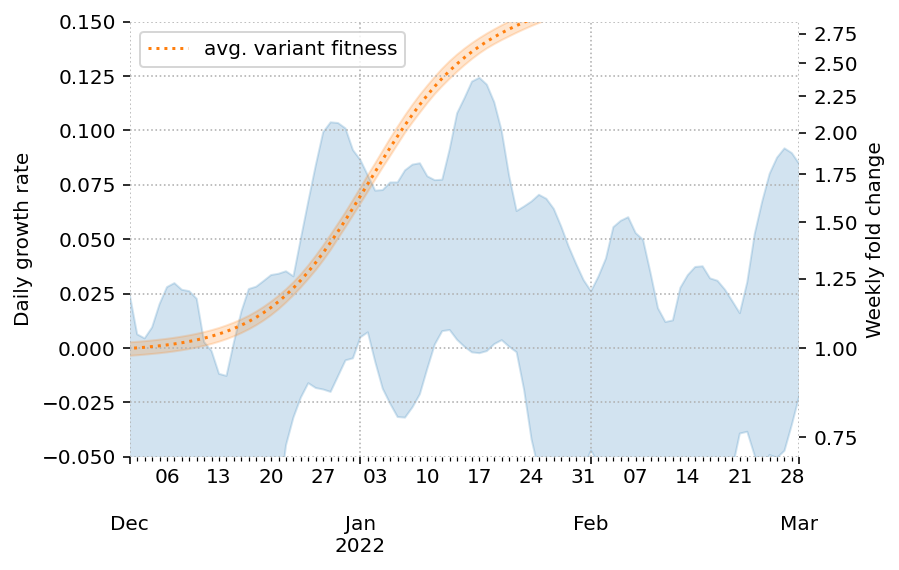

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


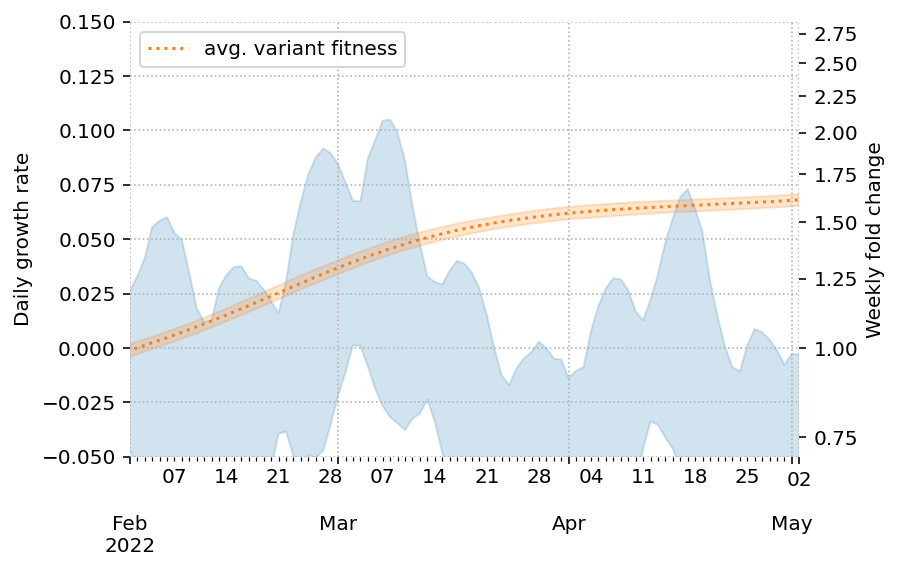

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


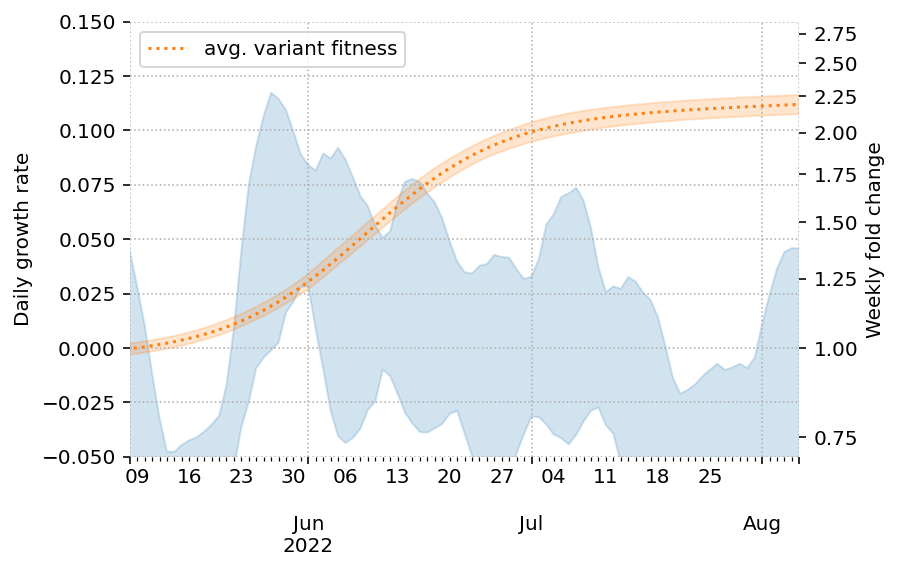

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


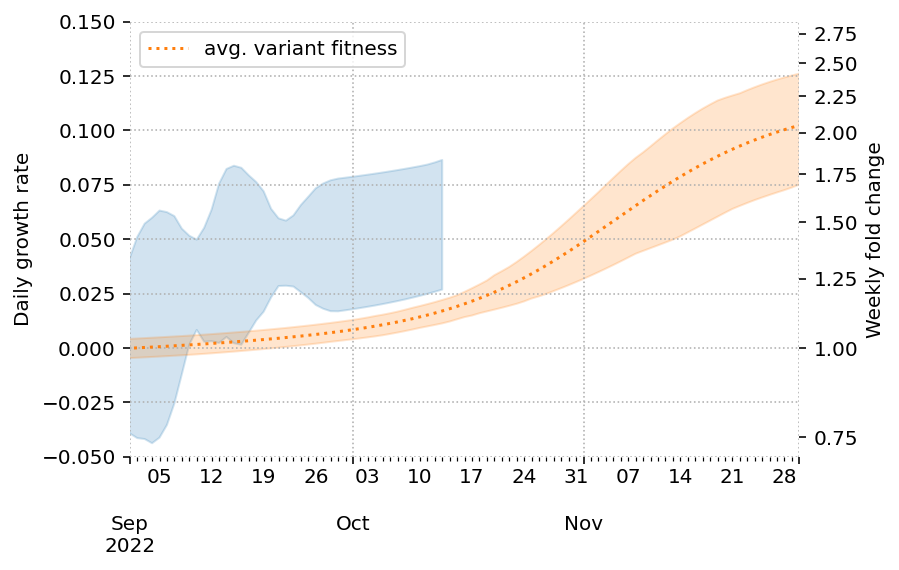

In [107]:
#plt.figure(figsize=(1,4))
for t in np.array(["2021-12-01","2022-02-01","2022-05-08","2022-09-01"]).astype("datetime64[D]"):
    pd.Series(np.nan, index=pd.date_range("2022-01-01","2022-07-01")).plot(label="", figsize=(6,4)) 
    t0 = cases_land.columns.to_list().index(t) #index(np.datetime64("2022-09-01"))
    y0 = 0 #r0.mean(0)[t0]

    #plt.plot(cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'),r0.mean(0) - r0.mean(0)[t0], label="total growth rate", c="C0", ls=":") 
    plt.fill_between(cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'), np.quantile(r0,0.05,0),np.quantile(r0,0.95,0), alpha=0.2, color="C0") 
    plt.plot(cases_land.columns[1] + np.arange(f.shape[1]).astype('timedelta64[D]'),f.mean(0)-f.mean(0)[t0] + y0, label="avg. variant fitness", ls=":") 
    #plt.bar(x=0 , height=(f[:,-1]-f[:,-29]).mean(0), label='lineage')
    plt.fill_between(cases_land.columns[1] + np.arange(f.shape[1]).astype('timedelta64[D]'),np.quantile(f-f.mean(0)[t0],0.05,0) + y0,np.quantile(f-f.mean(0)[t0]+y0,0.95,0), alpha=0.2, color="C1") 
    #plt.xlim(("2022-09-01","2022-11-30"))
    plt.xlim((t, t+np.timedelta64(90,"D")))
    plt.ylim((-0.05,0.15))
    plt.ylabel("Daily growth rate")
    plt.legend(loc='upper left')

    secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*7), lambda x: np.log(x)/7))
    secax.set_ylabel('Weekly fold change')
    #secax.set_yscale('log')
    #secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
    secax.spines['right'].set_visible(False)
    plt.show()

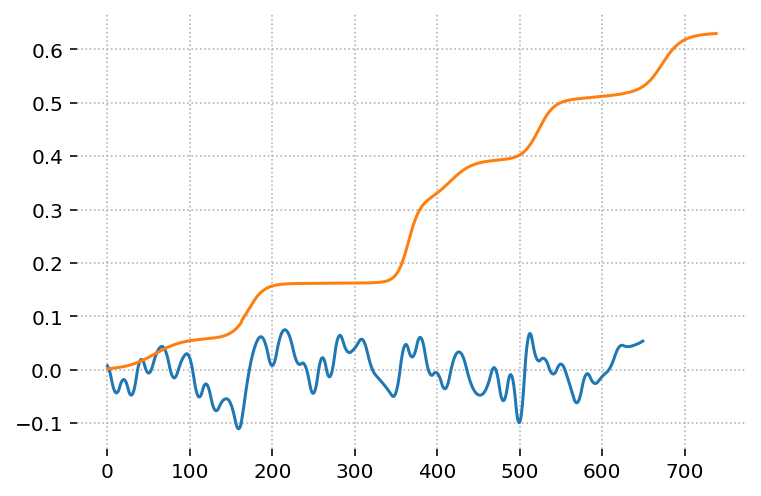

In [108]:
plt.plot(r0.mean(0))
plt.plot(f.mean(0))


45

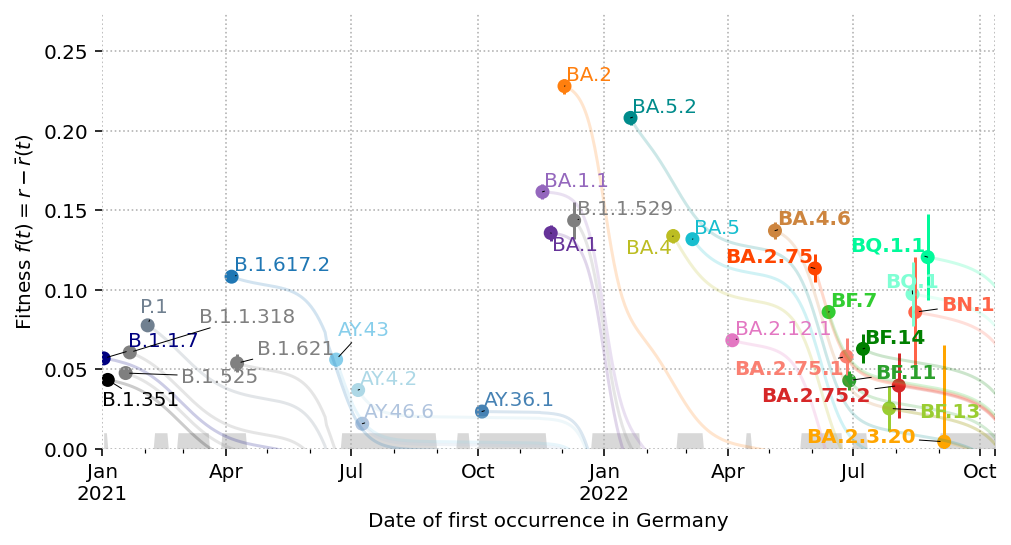

In [109]:
x = (GG[-1].cumsum(0)>0).argmax(0)
pd.Series(np.nan, index=np.arange("2021-01-01",np.datetime64('today'))).plot()
plt.xlim(("2021-01-01",np.datetime64('today')))
plt.fill_between(x=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'),y1=0, y2=(r0.mean(0)>0)*0.01, color='grey', alpha=0.3, lw=0) 

df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-1,:]
df["Relative growth advantage f"].plot(ls="", figsize=(8,4))
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-1], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
for i in range(df.shape[0]):
    j = merged_lineages_alias.index(df.Lineage[i])
    plt.plot(cases_land.columns[x[j]] + np.arange(f.shape[1]-x[j]).astype("timedelta64[D]"), (r[:,[j]]-f[:,x[j]:]).mean(0), c=lineage_colors[df.Lineage[i]], ls="-", alpha=0.2)
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
#plt.xlabel('')
plt.ylabel("Fitness $f(t) = r-\\bar{r}(t)$")
for l in text:
    if l.get_text() in escape_lineages:
        l.set_weight('bold')
plt.ylim((0.00,None))
#secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.log(2)/x, lambda x: 1/np.log(2)/x))
#secax.set_ylabel('Doubling time')
#secax.set_yscale('log')
#secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
#secax.spines['right'].set_visible(False)

adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [110]:
np.mean(model.posterior['c1'].squeeze(),0)

array([ -5.641012 ,  -3.753978 ,  -9.630551 ,  -8.007473 ,  -9.939479 ,
        -6.689544 ,  -9.0293865, -12.23307  ,  -4.347409 ,  -4.9612565,
        -9.284148 ,  -6.829668 ,  -4.462549 ,  -6.2974977, -11.823343 ,
        -9.982935 ,  -9.7425   , -21.838858 ,  -4.892966 ,  -4.566078 ,
        -3.813584 ,  -5.7214527,  -5.5406647,  -6.14774  ,  -6.1971364,
        -7.051752 ,  -8.750884 ,  -7.2730107,  -5.7381053,  -3.233378 ,
        -3.8104742,  -8.507578 ,   0.       ], dtype=float32)

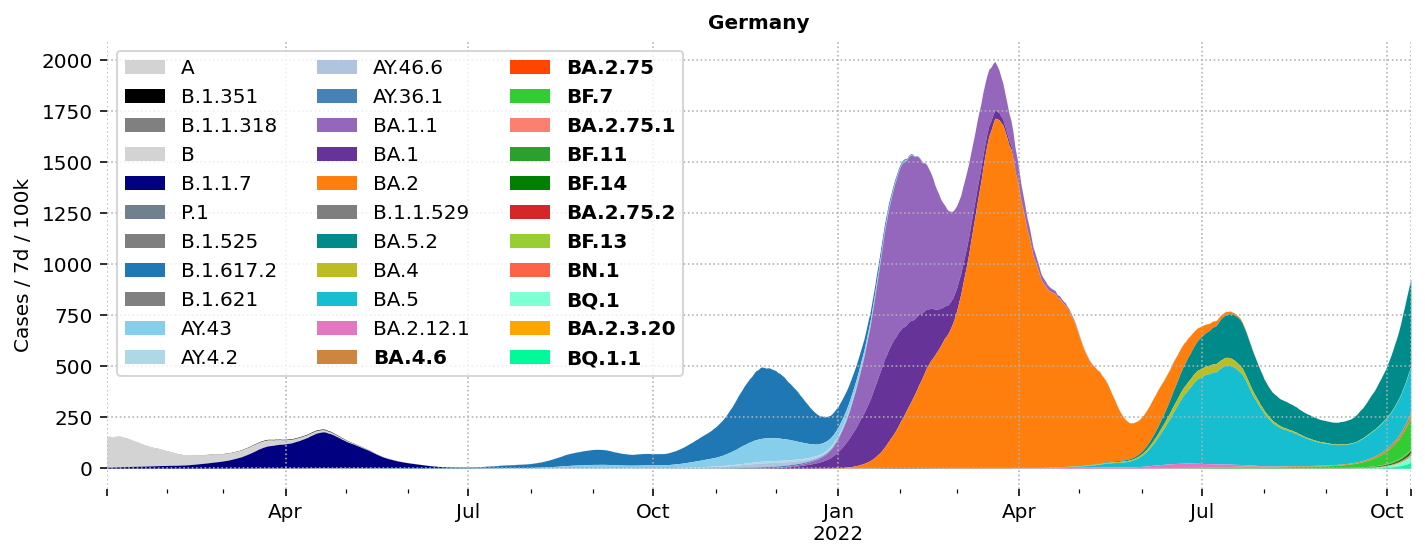

In [111]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:], columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,o].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
leg = ax[-1].legend(title=None, ncol=3, loc='upper left')
for l in leg.get_texts():
    if l.get_text() in escape_lineages:
        l.set_weight('bold')

plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [112]:
pp.shape

(100, 1, 739, 33)

Text(63.125, 0.5, 'Variant proportion')

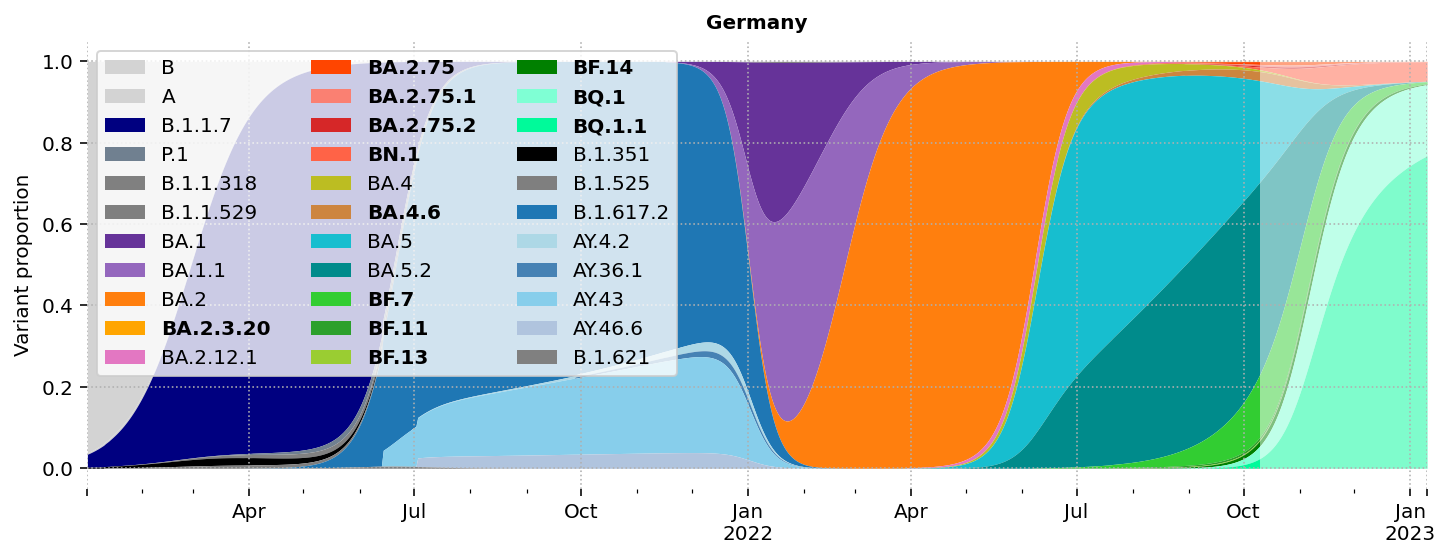

In [113]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    #y = pd.DataFrame(λ[i,:,:]/λ[i].sum(-1, keepdims=True), columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = pd.DataFrame(pp.mean(0).squeeze(), columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(pp.shape[2]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)#* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    #ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
#ax[-1].legend(loc='upper left', title=None, ncol=4)
leg = ax[-1].legend(title=None, ncol=3, loc='upper left')
for l in leg.get_texts():
    if l.get_text() in escape_lineages:
        l.set_weight('bold')
ax[-1].axvspan(cases_land.columns[-1], y.index[-1], facecolor='w',alpha=0.5, lw=0.5)
    
plt.tight_layout()
plt.ylabel('Variant proportion')
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [114]:
cases_land.columns[-1]

Timestamp('2022-10-10 00:00:00')

In [115]:
p = np.quantile(model.get_probabilities().squeeze(), (0.05,0.5,0.95),0)

In [116]:
p.shape

(3, 650, 33)

In [117]:
p[1,-50:,merged_lineages_alias.index("BQ.1.1")]

array([0.00010844, 0.00012319, 0.00013962, 0.00015833, 0.00017889,
       0.00020259, 0.00023012, 0.000261  , 0.00029491, 0.00033349,
       0.00037612, 0.00042445, 0.00047799, 0.00054249, 0.00061347,
       0.0006963 , 0.00078326, 0.00088481, 0.00100239, 0.00113173,
       0.00127141, 0.00143406, 0.00161138, 0.00179611, 0.00203882,
       0.00230388, 0.00256475, 0.00286216, 0.00319497, 0.00356545,
       0.00399942, 0.00447695, 0.00502666, 0.00562771, 0.0063078 ,
       0.00709203, 0.00788059, 0.00875111, 0.00978158, 0.01096805,
       0.01227378, 0.01365566, 0.01515102, 0.01680814, 0.01876658,
       0.02076145, 0.02308702, 0.02564227, 0.02845893, 0.0317179 ])

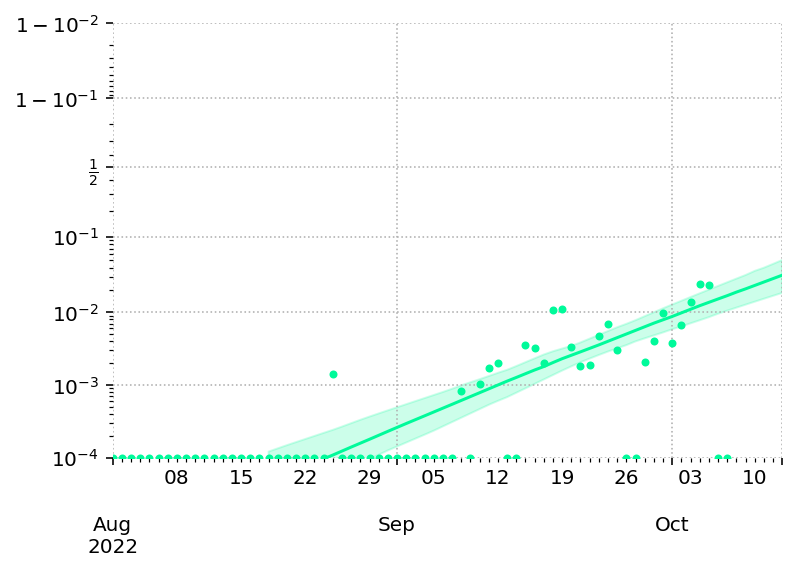

In [120]:
#plt.plot(GG[-1,:,-1]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,0]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,-3]/GG[-1].sum(-1))
#plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
t = cases_land.columns[1] + np.arange(p.shape[1]).astype('timedelta64[D]')
pd.Series(np.nan, index=t).plot()
plt.plot(t[:-6],(GG[-1,:,merged_lineages_alias.index("BQ.1.1")]/GG[-1].sum(-1) + 1e-4), ls="", marker=".", c=lineage_colors['BQ.1.1'])
plt.plot(t, p[1,:,merged_lineages_alias.index("BQ.1.1")], c=lineage_colors['BQ.1.1'])
plt.fill_between(x=t, y1=p[0,:,merged_lineages_alias.index("BQ.1.1")], y2=p[2,:,merged_lineages_alias.index("BQ.1.1")], color=lineage_colors['BQ.1.1'], alpha=0.2)
#plt.plot(GG[-1,:,merged_lineages_alias.index("BQ.1")]/GG[-1].sum(-1), ls="", marker=".")
#plt.plot(p[:,merged_lineages_alias.index("BQ.1")])
plt.xlim(("2022-08-01",None))
plt.ylim((1e-4,1-1e-2))
plt.yscale('logit')

In [121]:
(np.quantile(np.argmax(pp.squeeze()[...,[x.startswith("BQ") for x in merged_lineages_alias]].sum(-1) > 0.5,1), 
            (0.05,0.5,0.95)).astype("timedelta64[D]") + cases_land.columns[0]).astype("datetime64[D]")

array(['2022-11-02', '2022-11-08', '2022-11-22'], dtype='datetime64[D]')

In [122]:
p.shape

(3, 650, 33)

In [123]:
dict(zip(merged_lineages_alias,model.posterior['c1'].squeeze().mean(0)))

{'A': -5.641012,
 'B.1.1.7': -3.753978,
 'P.1': -9.630551,
 'B.1.1.318': -8.007473,
 'B.1.1.529': -9.939479,
 'BA.1': -6.689544,
 'BA.1.1': -9.0293865,
 'BA.2': -12.23307,
 'BA.2.3.20': -4.347409,
 'BA.2.12.1': -4.9612565,
 'BA.2.75': -9.284148,
 'BA.2.75.1': -6.829668,
 'BA.2.75.2': -4.462549,
 'BN.1': -6.2974977,
 'BA.4': -11.823343,
 'BA.4.6': -9.982935,
 'BA.5': -9.7425,
 'BA.5.2': -21.838858,
 'BF.7': -4.892966,
 'BF.11': -4.566078,
 'BF.13': -3.813584,
 'BF.14': -5.7214527,
 'BQ.1': -5.5406647,
 'BQ.1.1': -6.14774,
 'B.1.351': -6.1971364,
 'B.1.525': -7.051752,
 'B.1.617.2': -8.750884,
 'AY.4.2': -7.2730107,
 'AY.36.1': -5.7381053,
 'AY.43': -3.233378,
 'AY.46.6': -3.8104742,
 'B.1.621': -8.507578,
 'B': 0.0}

In [124]:
1/(1+np.exp(-2))

0.8807970779778823

In [125]:
c = model.posterior['c1'].mean(0)
b = model.posterior['b1'].mean(0)
c.shape

(1, 1, 33)

In [126]:
b.shape

(1, 1, 33)

In [127]:
t,g = model.clock()

In [128]:
l0 = t * b + g + c

(-20.0, 100.0)

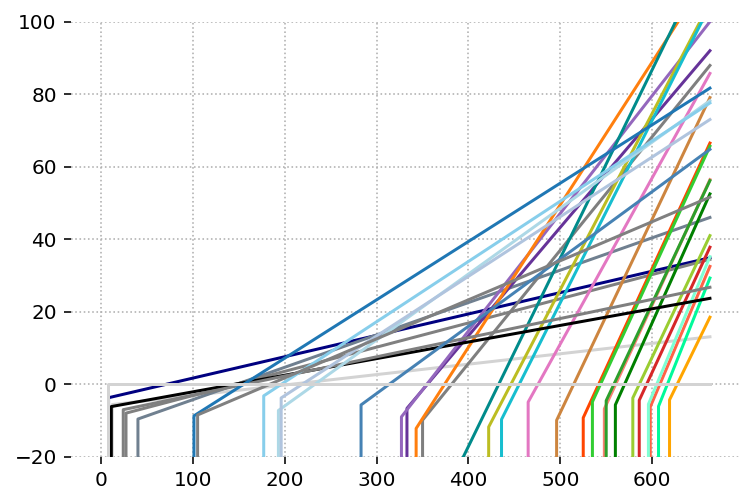

In [129]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))


In [130]:
lb = np.einsum('ji,jil->jl',
                    logsumexp(l0, -1), #jnp.max(logits,-1),
                    (t==0) * (g==0))

In [131]:
lb

array([[3.4724876e-02, 2.3154248e-02, 1.5960611e-01, 7.9602599e-02,
        3.1318909e+01, 2.8583157e+01, 2.7617611e+01, 3.0192415e+01,
        9.7143478e+01, 4.9826668e+01, 6.0117683e+01, 6.8398697e+01,
        8.3354660e+01, 8.8141663e+01, 4.2906055e+01, 5.4817524e+01,
        4.5159218e+01, 3.7917046e+01, 6.3391296e+01, 6.9182846e+01,
        8.0590157e+01, 7.3111649e+01, 8.7336212e+01, 9.1844376e+01,
        2.9551135e-02, 6.7413338e-02, 1.9346638e+00, 7.4967308e+00,
        2.0537535e+01, 6.3281016e+00, 7.7576604e+00, 2.1383157e+00,
        0.0000000e+00]], dtype=float32)

(-20.0, 100.0)

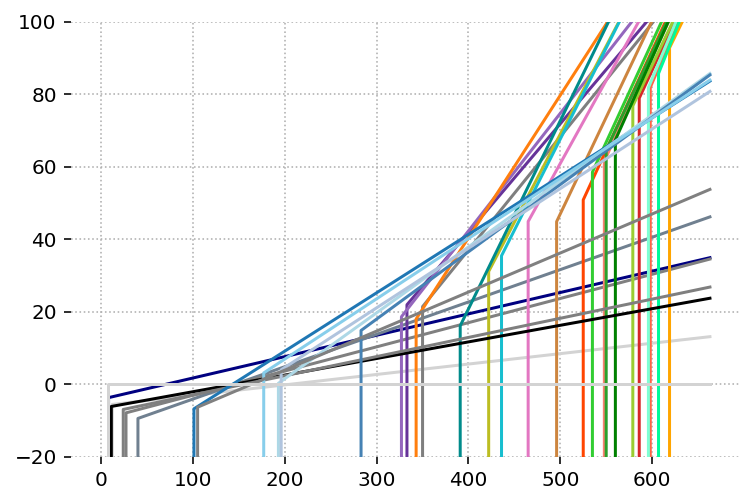

In [132]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i]+lb[0,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))

In [133]:
bak.loc[bak.index.str.startswith("B.1"),:]

counts       date
B.1.1.7      97117 2021-01-11
B.1.617.2    19935 2021-04-12
B.1.177.86    3501 2021-01-08
B.1.177.81    3058 2021-01-08
B.1.177       2805 2021-01-04
B.1           2530 2021-01-06
B.1.221       2370 2021-01-05
B.1.160       2069 2021-01-04
B.1.351       1940 2021-01-18
B.1.1         1899 2021-01-06
B.1.258       1883 2021-01-09
B.1.1.317     1231 2021-01-16
B.1.177.62     902 2021-01-12
B.1.525        857 2021-02-01
B.1.258.17     750 2021-01-18
B.1.1.318      522 2021-02-19
B.1.1.529      473 2021-12-29
B.1.1.70       425 2021-01-11
B.1.177.75     294 2021-01-08
B.1.1.385      277 2021-01-12
B.1.619        239 2021-03-17
B.1.1.519      234 2021-02-08
B.1.1.39       232 2021-01-14
B.1.1.297      224 2021-01-14
B.1.2          208 2021-01-20
B.1.221.2      192 2021-01-07

In [134]:
pd.Series(GG[-1].sum(0), index=merged_lineages_alias)

A               693.0
B.1.1.7       97705.0
P.1             923.0
B.1.1.318      1175.0
B.1.1.529       547.0
BA.1          58270.0
BA.1.1       108976.0
BA.2         262365.0
BA.2.3.20        11.0
BA.2.12.1      3915.0
BA.2.75         139.0
BA.2.75.1        67.0
BA.2.75.2        53.0
BN.1             36.0
BA.4           6528.0
BA.4.6          937.0
BA.5          78491.0
BA.5.2        42629.0
BF.7           3116.0
BF.11           209.0
BF.13            61.0
BF.14           169.0
BQ.1            133.0
BQ.1.1           76.0
B.1.351        1974.0
B.1.525         857.0
B.1.617.2    175405.0
AY.4.2         3101.0
AY.36.1        2213.0
AY.43         49175.0
AY.46.6        8708.0
B.1.621         165.0
B             30565.0
dtype: float64

In [135]:
CC[-1,-10:]

array([ 26734.        ,  18110.        ,  21939.        , 122272.70384943,
       141321.50383285, 135176.81893377, 110815.61443283,  27954.33058701,
        20514.32073604, 142798.94190966])

In [136]:
cases_land.columns

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04',
               '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08',
               '2022-10-09', '2022-10-10'],
              dtype='datetime64[ns]', name='Refdatum', length=648, freq=None)

In [137]:
genomes.sum(level=1).sum(1)

date
2021-01-01     11
2021-01-02     25
2021-01-03     22
2021-01-04     64
2021-01-05     44
             ... 
2022-10-02    367
2022-10-03    632
2022-10-04    391
2022-10-05    135
2022-10-07     82
Length: 644, dtype: int64

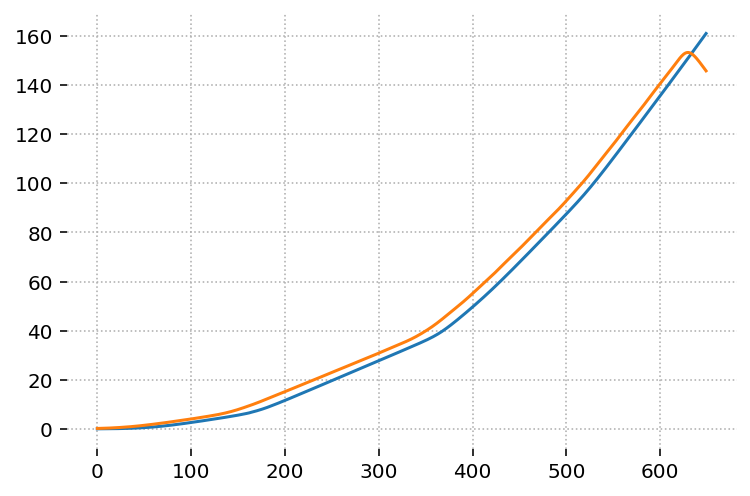

In [138]:
plt.plot(lse)
plt.plot(B0[0] @ lse[np.linspace(0,B0.shape[1]-1, B0.shape[2]).astype("int")])

In [139]:
lse

array([3.87019813e-02, 4.08599488e-02, 4.31391038e-02, 4.55460027e-02,
       4.80877832e-02, 5.07716835e-02, 5.36053441e-02, 5.65967299e-02,
       5.97542673e-02, 6.30867854e-02, 6.74699470e-02, 7.12240413e-02,
       7.51840547e-02, 7.96935335e-02, 8.41188729e-02, 8.87843519e-02,
       9.37019661e-02, 9.88843068e-02, 1.04344137e-01, 1.10095017e-01,
       1.16150931e-01, 1.22525938e-01, 1.29235253e-01, 1.36293963e-01,
       1.43717855e-01, 1.51523143e-01, 1.59792185e-01, 1.68416053e-01,
       1.77472845e-01, 1.86980367e-01, 1.96956605e-01, 2.07419902e-01,
       2.18389079e-01, 2.29882732e-01, 2.41919875e-01, 2.54519582e-01,
       2.67700821e-01, 2.81482577e-01, 2.95883805e-01, 3.10923249e-01,
       3.26619118e-01, 3.42989802e-01, 3.60052824e-01, 3.77825528e-01,
       3.96324217e-01, 4.15564835e-01, 4.35562849e-01, 4.56332147e-01,
       4.77886260e-01, 5.00237525e-01, 5.23397326e-01, 5.47375679e-01,
       5.72181463e-01, 5.97822547e-01, 6.24305010e-01, 6.51633918e-01,
      

In [140]:
pd.Series(GG[-1].sum(1), index=genomes.index.levels[1])[-20:]

date
2022-09-17     371.0
2022-09-18     275.0
2022-09-19    1217.0
2022-09-20    1141.0
2022-09-21     557.0
2022-09-22     649.0
2022-09-23     585.0
2022-09-24     343.0
2022-09-25     184.0
2022-09-26     609.0
2022-09-27     510.0
2022-09-28     508.0
2022-09-29     525.0
2022-09-30     274.0
2022-10-01     302.0
2022-10-02     365.0
2022-10-03     628.0
2022-10-04     389.0
2022-10-05     134.0
2022-10-07      81.0
dtype: float64

In [141]:
foo.iloc[-10:,]

BF.26        197
BF.4         193
B.1.221.2    192
BA.2.38      191
AY.61        190
C.35         186
AY.75        185
BA.2.11      184
BA.5.1.1     181
BA.2.3.9     176
Name: lineage, dtype: int64

In [142]:
pd.DataFrame(p, columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')).to_csv(f"Lineage_proportions_{np.datetime64('today')}.csv")

ValueError: Must pass 2-d input. shape=(3, 650, 33)

In [ ]:
alias("BN.1", anti_alias=True)

In [152]:
tmp = pd.DataFrame(G[:,-21:].sum(1), index=cases_land.index, columns=merged_lineages_alias).transform(lambda x: x/sum(x), axis=1)

In [153]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")


<AxesSubplot:>

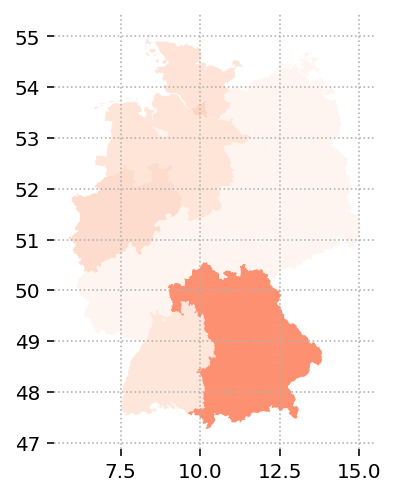

In [157]:
bl.merge(tmp, left_index=True, right_index=True).plot("BQ.1.1", cmap="Reds", vmin=0, vmax=0.05)

<AxesSubplot:>

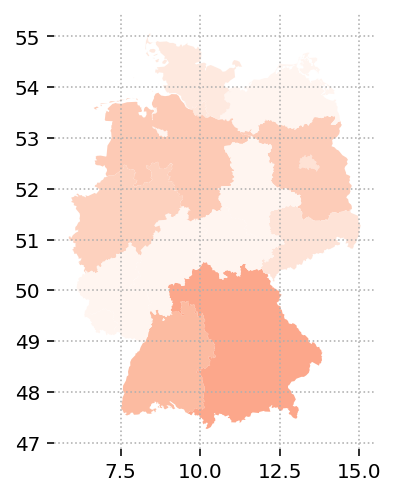

In [158]:
bl.merge(tmp, left_index=True, right_index=True).plot("BQ.1", cmap="Reds", vmin=0, vmax=0.05)